# Methods for Data Science: Course Work 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy.sparse import linalg
from scipy.stats import multivariate_normal 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)


These are the datasets containing clean images from MNIST which we will be using in Task 1.

In [2]:
mnist_train = pd.read_csv('MNIST_train.csv')
mnist_test = pd.read_csv('MNIST_test.csv')

# Validity check
print("---------------Validity Check for Clean Training Set---------------")
print("---Check for numerical columns (without 'Type' column)---")
print(all([mnist_train[column].dtype.kind in 'iufcb' for column in mnist_train.columns[:-1]]))
print("---Check for Inf/NaN (All columns)---")
print((mnist_train.isin([np.inf, -np.inf]).any() & mnist_train.isnull().any()).any())

print("---------------Validity Check for Clean Test Set---------------")
print("---Check for numerical columns (without 'Type' column)---")
print(all([mnist_test[column].dtype.kind in 'iufcb' for column in mnist_test.columns[:-1]]))
print("---Check for Inf/NaN (All columns)---")
print((mnist_test.isin([np.inf, -np.inf]).any() & mnist_test.isnull().any()).any())

mnist_train.head()

---------------Validity Check for Clean Training Set---------------
---Check for numerical columns (without 'Type' column)---
True
---Check for Inf/NaN (All columns)---
False
---------------Validity Check for Clean Test Set---------------
---Check for numerical columns (without 'Type' column)---
True
---Check for Inf/NaN (All columns)---
False


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From the first 5 rows we can have a taste what does the dataset look like. And the from the output message, we can see that those two datasets are all numerical and not having any invalid value.

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

###### 1.1.1

Let us define the standardise function before proceeding. 

In this coursework, I choose to standardise the test set using mean and variance from training set, unless stated otherwise. This is because I want to keep mean and variance as part of my model. A 'revert' method is included, this is meant to rescale a standardised dataset back to its original scale.

In [3]:
def standardise(X, Xtest=None, Xrevert=None):
    """
    This function perform standarisation to given training and test dataset. It also 
    allows one to re-scale a standardised dataset back.

    :param X: 2d array, training set
    :param Xtest: 2d array, test set
    :param Xrevert: 2d array, standardised set to be scaled back

    :return Xbar: 2d array, updated dataset
    """
    # Mean and variance of traning set
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.

    # Standardise the training set
    Xbar = ((X-mu)/std_filled)

    if Xtest is not None:
        # Standarise test set
        Xbar = ((Xtest-mu)/std_filled)

    if Xrevert is not None:
        # Scale standardised set back
        Xbar = Xrevert * std_filled + mu
        
    return Xbar

Now let us take out the image set and label set respectively. 

To standardise the MNIST image set, we first convert uint8 encoding of pixels to a floating point number between 0 and 1, and then perform our tranditional standardisation.

In [4]:
# Traning set
mnist_train_numpy = mnist_train.to_numpy()
Xmnist_train = mnist_train_numpy[:,1:] 
Xmnist_train_01 = Xmnist_train / 255. # Convert to floating number between 0 and 1
Xmnist_train_std = standardise(Xmnist_train_01) # Standardise
ymnist_train = mnist_train_numpy[:,:1].flatten() # Convert (6000,1) into (6000,)

# Test set
mnist_test_numpy = mnist_test.to_numpy()
Xmnist_test = mnist_test_numpy[:,1:]
Xmnist_test_01 = Xmnist_test / 255.
Xmnist_test_std = standardise(Xmnist_train_01, Xmnist_test_01)
ymnist_test = mnist_test_numpy[:,:1].flatten()

In this section, we aim at training by stochastic gradient descent a MLP with $L=3$ hidden layers with 200 neurons each, and produce an output layer with 10 neurons.

Given weight $W$ and bias $b$, we first define each pre-activation layer (dense) as
$$
h^{(0)} := x
$$
$$
a^{(k+1)} = W^{(k)}h^{(k)} + b^{(k)} \quad \text{for} \quad k=0, ..., L
$$


The post-activation layer is defined as
$$
h^{(k)} = \sigma(a^{(k)}) \quad \text{for} \quad \text{k = 1, ..., L}
$$
and 
$$
h^{(L+1)} = \sigma_{\text{out}}(a^{(L+1)})
$$
for some activate functions which will be defined later.

In [5]:
def dense(h, W, b):
    """
    Computes the dense layer output for a given set of inputs, kernel matrix and bias parameters.
    
    :param h: (K x h_in) 2d array of inputs, 
        where K is the number of samples and h_in is the number of input features.
    :param W: (h_in x h_out) 2d array, weights
    :param b: (h_out) 1d array for bias parameters
    
    :return h: (K x h_out) 2d array of output values, preactivation layer
    """
    h = b + h @ W
    return h

Here we define our softplus activation function
$$
\sigma(a) = \frac{log(1 + e^{\beta a})}{\beta}
$$
To prevent overflow, softplus is approximated by
$$
\sigma(a_{i,j}) = a_{i,j} \quad \text{if} \quad \beta a_{i,j} > 20
$$
which is a convention in PyTorch.

Next, softmax output layer activation function is defined by
$$
\sigma_{out}(a^{L+1})_j = \frac{e^{a_j}}{\sum_i e^{a_i}}
$$
To prevent overflow, it is approximated by subtracting the maximum from the input. Due to the nature of exponential function, this is essentially only differ by a constant multiplier.

In [6]:
# Activation function for hidden layers
def softplus(X, beta=1):
    """
    This function defines the softplus activation function.
    
    :param X: (M x N) 2d array, pre-activation layer
    :param beta: constant multiplier, default at 1
    
    :return softplux_X: (M x N) 2d array, post-activation layer
    """
    # Prevent overflow
    softplus_X = np.where(beta * X > 20, X, np.log(1. + np.exp(beta * X)) / beta)
    return softplus_X

# Activation function for output layer
def softmax(x):
    """
    This function defines the softmax activation function.
    
    :param X: (M x N) 2d array, pre-activation output layer
    
    :return softmax: (M x N) 2d array, output layer
    """
    # Subtract the maximum value of x to prevent overflow
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    exp_sum = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / exp_sum

Define our loss function as KL-divergence
$$
\mathcal{L}(y_{\text{true}} , y_{\text{pred}}) = \frac{1}{n} \sum_i^n {y_{\text{true}}}_i \cdot (log({y_{\text{true}}}_i) - log({y_{\text{pred}}}_i))
$$

It is worth pointing out that I will use one-hot encoding here which means both $y_{\text{true}}$ and $y_{\text{pred}}$ will be matrices rather than vectors.

Now we compute the output error, for $1 \leq j \leq n$,
$$
\begin{aligned}
\delta^{(4)} &= \frac{\partial \mathcal{L}}{\partial a_i^{(4)}}\\
&= \sum_{j=1}^n \frac{\partial \ell}{\partial h_j} \frac{\partial h_j}{\partial a_i^{(4)}}\\
&= \sum_{j=1}^n (\frac{-y_j}{h_j})(\delta_{i,j}h_j - h_jh_i)\\
&= -y_i + y_i(\sum_{j=1}^n h_j)\\
&= -y_j + h_j
\end{aligned}
$$
Notice we have used the fact that the sum of activated output layer is $1$.

In [7]:
def KL_loss(y_true, y_pred):
    """
    This function calculates the Kullback-Leibler divergence of how true probability 
    distribution is different from a predicted probability distribution.

    :param y_true: 2d array, true labels
    :param y_pred: 2d array, predicted labels

    :param KL: 1d array, KL loss of each row
    """
    loss_pointwise = y_true * (np.log(y_true+1e-8) - np.log(y_pred+1e-8))
    return np.mean(np.sum(loss_pointwise, axis=1))

def output_error(y_batch, outputlayer):
    """
    This function calculates the output error of the MLP. 
    This is implememted by using backpropagate algorithm.

    :param y_batch: 2d array, true labels
    :param outputlayer: 2d array, predicted labels
    """
    return - y_batch + outputlayer

After obtaining $\delta^{(4)}$, given weights $W^{(3)}$ and bias $b^{(3)}$, we backpropogate it to get $\delta^{(3)}$. Continuously until we get $\delta^{(1)}$. 

The algorithm is 
$$
\delta^{(k)} = \sigma(a^{(k)})^\prime W^{(k)} \delta^{(k+1)}
$$
Before proceeding, let us find the derivative of our activation function for hidden layers,
$$
\frac{\partial \sigma}{\partial a} = \frac{1}{\beta}\frac{\beta e^{\beta a}}{1 + e^{\beta a}} = \frac{e^{\beta a}}{1 + e^{\beta a}}
$$
It is worth noticing as I performed a linear approximation in softplus activation to prevent overflow, here I accordingly set the derivative of those linear approximation to be $1$.


In [8]:
# Derivative of softplus activation function
def activation_derivative(a, beta=1):
    """
    This function finds the piecewise derivative of our softplus activation.
    
    :param a: 2d array, the pre-activation layer
    :param beta: int, constant multiplier

    :return activation_derivative: 2d array, derivative of activation function
    """
    return np.where(a <= 20, np.exp(beta * a) / (1 + np.exp(beta * a)), 1) 

# Backpropagate
def backpropagate(delta, W, a):
    """
    This function implements the backpropagation algorithm.

    :param delta: 2d array, layer errors
    :param W：2d array, weight
    :param a: 2d array, pre-activations

    :return: 2d array of layer errors 
    """
    
    return np.dot(delta, W.T) * activation_derivative(a) 

To perform the stochastic gradient descent, we need to workout the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$. So that we can update the weights and biases iteratively.

In [9]:
def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3):
    """
    This function calculates the gradient of weights and bias.

    :param delta: 2d array, layer erros
    :param h: 2d array, post-activations

    :return grad_W: gradient of weights
    :return grad_b: gradient of bias
    """
    
    m = h0.shape[0]
    grad_W3 = 1/m * np.dot(delta4.T, h3)
    grad_b3 = np.mean(delta4, axis=0)
    
    grad_W2 = 1/m * np.dot(delta3.T, h2)
    grad_b2 = np.mean(delta3, axis=0)
    
    grad_W1 = 1/m * np.dot(delta2.T, h1)
    grad_b1 = np.mean(delta2, axis=0)
    
    grad_W0 = 1/m * np.dot(delta1.T, h0)
    grad_b0 = np.mean(delta1, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

Here we define a function to make prediction based on some trained weights and biases, and then it compute the accuracy of our prediction.

In [10]:
def predict_accuracy(X, y, W0, b0, W1, b1, W2, b2, W3, b3):
    """
    This function predicts the labels using trained weights and bias, and then 
    calculate the accuracy of prediction.

    :param X: 2d array, full MNIST dataset
    :param y: 1d array, full labels
    :param W: 2d array, trained weights
    :param b: 1d array, trained bias

    :return y_pred: 1d array, predicted labels
    :return accuracy: float, accuracy of this prediction
    
    """

    # Train
    a1 = dense(X, W0, b0)
    h1 = softplus(a1)
    # second hidden layer
    a2 = dense(h1, W1, b1)
    h2 = softplus(a2)
    # third hidden layer
    a3 = dense(h2, W2, b2)
    h3 = softplus(a3)
    # output layer
    a4 = dense(h3, W3, b3)
    h4 = softmax(a4)
    
    # Predict
    y_pred = np.argmax(h4, axis=1)
    # Accuracy
    accuracy = np.mean(np.array(y) == np.array(y_pred))

    return y_pred, accuracy

Let us now write a small function to help us initialise weights and bias based on Glorot initialisation introduced in the exercise.

In [11]:
def Glorot_initial(n0, hidden_neuron, output_neuron):
    """
    This function defines the initialisation of weights and bias based on Glorot.

    :param n0: int, dimension of input layer attributes
    :param hidden_neuron: int, number of neurons of hidden layers
    :param output_neuron: int, number of neurons of output layer

    :return W: initialised weights
    :return b: initialised bias
    """
    var0 = 2. / (hidden_neuron + n0)
    W0 = np.random.randn(n0, hidden_neuron) * np.sqrt(var0)
    b0 = np.zeros(hidden_neuron)

    var1 = 2. / (hidden_neuron + hidden_neuron)
    W1 = np.random.randn(hidden_neuron, hidden_neuron) * np.sqrt(var1)
    b1 = np.zeros(hidden_neuron)

    var2 = 2. / (hidden_neuron + hidden_neuron)
    W2 = np.random.randn(hidden_neuron, hidden_neuron) * np.sqrt(var2)
    b2 = np.zeros(hidden_neuron)

    var3 = 2. / (output_neuron + hidden_neuron)
    W3 = np.random.randn(hidden_neuron, output_neuron) * np.sqrt(var3)
    b3 = np.zeros(output_neuron)

    return W0, b0, W1, b1, W2, b2, W3, b3

Now we can sum up everything and use stochastic gradient descent to train our MLP model.

In [12]:
def sgd_mlp(X, y, learning_rate, batch_size=128, epoches=40, hidden_neuron=200, output_neuron=10, Xtest=None, ytest=None, param=False):
    """
    This function use stochastic gradient descent to train a multi-layer perceptron.

    :param X: 2d array, MNIST training set
    :param y: 1d array, training labels
    :param learning_rate: float, learning rate of gradient descent
    :param batch_size: int, size of each minibatch in SGD
    :param epoches: int, number of epoches we used to train the MLP
    :param hidden_neuron: int, number of neurons of hidden layer
    :param output_neuron: int, number of neurons of output layer
    :param Xtest: boolean, 2d array, MNIST test set
    :param ytest: boolean, 1d array, test labels
    :param param: boolean, whether return trained weights and bias

    :return losses: 1d array, KL loss of each epoch
    :return accuracy_train/accuracy_test: float, accuracy of prediction on training/test set
    :return Ws, bs: 2d/1d array, trained weights and bias
    """

    #Initialisation
    losses = np.zeros(epoches)
    accuracy_train = np.zeros(epoches)
    accuracy_test = np.zeros(epoches)
    
    # Glorot initialisation for weights and bias
    W0, b0, W1, b1, W2, b2, W3, b3 = Glorot_initial(X.shape[1], hidden_neuron,
                                                   output_neuron)

    # Batches for sgd
    indices = np.arange(X.shape[0])
    batch_num = np.ceil(X.shape[0] / batch_size).astype(int)

    for epoch in range(epoches):
        # Shuffle at each epoch
        np.random.shuffle(indices)
        # Iterate through each batch
        for i in range(batch_num):
            batch_idx = indices[i*batch_size:(i+1)*batch_size]
            X_b, y_b = X[batch_idx], y[batch_idx]
            
            # first hidden layer
            a1 = dense(X_b, W0, b0)
            h1 = softplus(a1)
            # second hidden layer
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            # third hidden layer
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            # output layer
            a4 = dense(h3, W3, b3)
            h4 = softmax(a4)
    
            # Backpropagating to find all the errors
            delta4 = output_error(np.eye(10)[y_b], h4)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            
            # Calculate gradients
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 =\
            grads(delta1, delta2, delta3, delta4, X_b, h1, h2, h3)
            
            # Update weights and bias
            W0 -= learning_rate * grad_W0.T
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1.T
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2.T
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3.T
            b3 -= learning_rate * grad_b3
        
        # Print our training progress
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} is completed.")
        
        # Analysis
        y_pred, accuracy_train[epoch] = predict_accuracy(X, y, W0, b0, W1, b1, W2, b2, W3, b3)
        # One-hot encoding, KL-loss on training set
        losses[epoch] = KL_loss(np.eye(10)[y], np.eye(10)[y_pred])
        
        if Xtest is not None:
            # Accuracy of prediction on test set
            _, accuracy_test[epoch] = predict_accuracy(Xtest, ytest, W0, b0, W1, b1, W2, b2, W3, b3)
    
    if Xtest is not None:
        return losses, accuracy_train, accuracy_test
    elif param:
        return W0, b0, W1, b1, W2, b2, W3, b3
    else:
        return losses

Upon request, let us fird train MLP on batches of 128 data points for 40 epochs. 

7 learning rates from 1e-5 to 1e-1 are searched across to find the optimal one which minimises the KL-loss at the end of training. We shall visualise the final loss.

In [13]:
learning_rates = np.logspace(-5, -1, 7)
losses = np.zeros(7)
for i, learning_rate in enumerate(learning_rates):
    print("learning_rate: ", learning_rate)
    losses[i] = sgd_mlp(Xmnist_train_std, ymnist_train, learning_rate=learning_rate)[-1]

learning_rate:  1e-05
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  4.641588833612782e-05
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  0.00021544346900318823
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  0.001
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  0.004641588833612777
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  0.021544346900318822
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
learning_rate:  0.1
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.


-------------------------------
Best Learning rate:  0.1
Resulting KL-divergence loss:  0.0


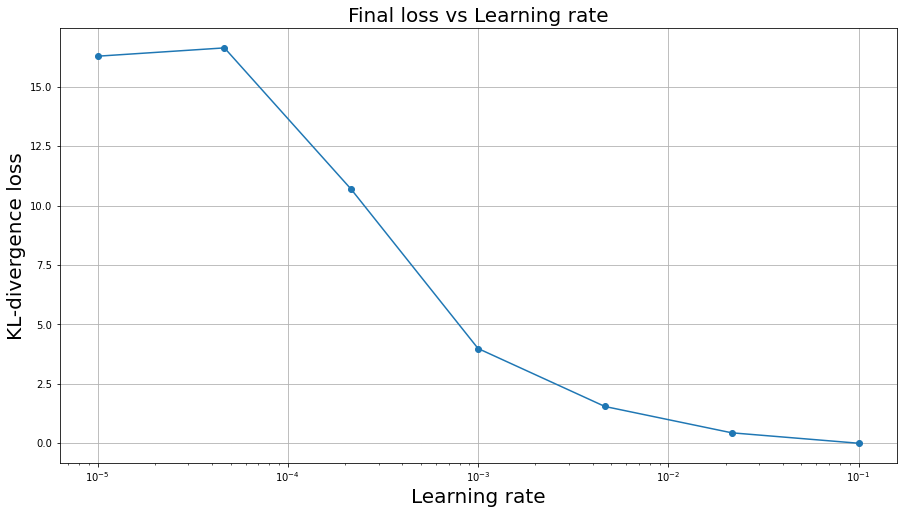

In [14]:
plt.figure(figsize=(15,8))
plt.semilogx(learning_rates, losses, marker='o', linestyle='-')
plt.xlabel('Learning rate', size=20)
plt.ylabel('KL-divergence loss', size=20)
plt.grid()
plt.title('Final loss vs Learning rate', size=20)

print("-------------------------------")
print("Best Learning rate: ", learning_rates[np.argmin(losses)])
print("Resulting KL-divergence loss: ", np.min(losses))

From the above figure, we can see as the learning rate increases from $1e-5$, the KL loss decreases in general. And eventually it reaches its minimum at $0.1$, the KL-divergence loss even reaches $0.0$. It means that our MLP predicts all the labels correctly. This is a marvelous job. 

###### 1.1.2

In this section, I will train the MLP using the optimal learning rate found in 1.1.1, and analyse its loss and accuracy on training and test set.

In [15]:
opt_learning_rate = 0.1
losses112, accuracy_train112, accuracy_test112 = sgd_mlp(Xmnist_train_std, ymnist_train, 
                                                        learning_rate=opt_learning_rate, 
                                batch_size=128, epoches=40, Xtest=Xmnist_test_std, ytest=ymnist_test)

Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.


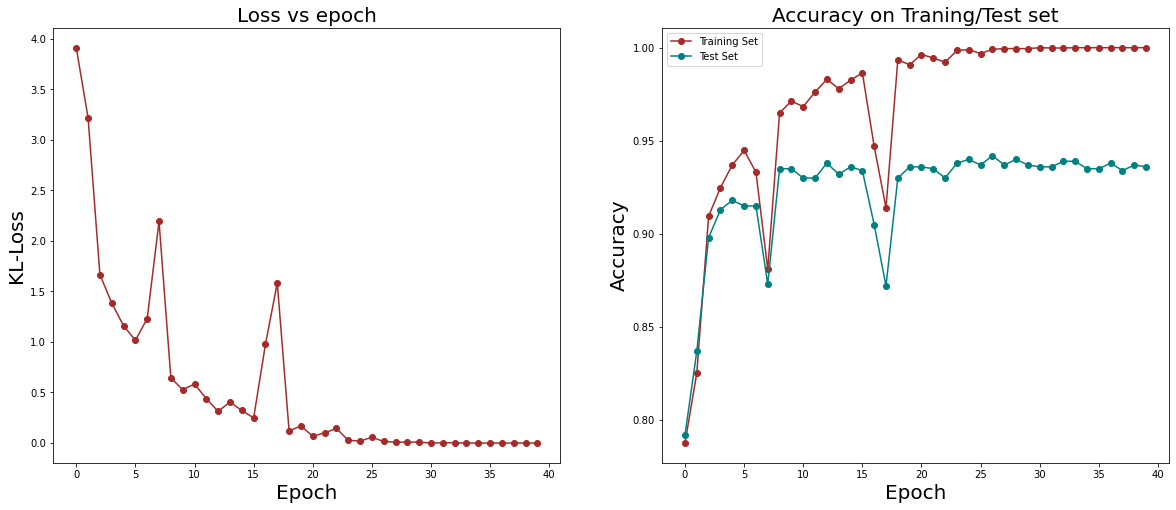

-------------------------------
Final Epoch KL-Loss:  0.0
Accuracy on training set:  1.0
Accuracy on test set:  0.936


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

ax1.plot(range(40), losses112, c='brown', marker='o', linestyle='-')
ax1.set_xlabel('Epoch', size=20)
ax1.set_ylabel('KL-Loss', size=20)
ax1.set_title('Loss vs epoch', size=20)

ax2.plot(range(40), accuracy_train112, c='brown', marker='o', linestyle='-', label = 'Training Set')
ax2.plot(range(40), accuracy_test112, c='teal', marker='o', linestyle='-', label = 'Test Set')
ax2.set_xlabel('Epoch',size=20)
ax2.set_ylabel('Accuracy', size=20)
ax2.set_title('Accuracy on Traning/Test set', size=20)

ax2.legend()
plt.show()

print("-------------------------------")
print("Final Epoch KL-Loss: ", losses112[-1])
print("Accuracy on training set: ", accuracy_train112[-1])
print("Accuracy on test set: ", accuracy_test112[-1])

We can firstly see that the KL-loss is generally decreasing epoch by epoch. Although some fluctuation happened, approximately after 26 epoches, the KL-loss has converged and reached the minimum 0.0. This means that our MLP is able to predict all the labels correctly.

This can be confirmed by the accuracy on training set which reachs 1.0 around the same epoch. This confirms that our MLP succesfully predicts all the labels.

Regarding the accuracy on test set, we can see that it is increasing simutaneously as accuracy on training set, slightly lower though. But it still reaches 0.936 in the end, which means our MLP has a good generalisation on the unseen set. Even though, it is always worth considering the probability of overfitting.

###### 1.1.3

In this section, I will reduce the neurons of hidden layers to 50, and re-train the MLP. Next, I will analyse it results and compare it to the 200 neuron case.

I will stick with the optimal learning rate found in 1.1.1 to make sure any difference in loss/accuracy is caused by the difference in number of neurons.

In [17]:
opt_learning_rate = 0.1
losses113, accuracy_train113, accuracy_test113 = sgd_mlp(Xmnist_train_std, ymnist_train.flatten(), 
                                                         learning_rate=opt_learning_rate, hidden_neuron=50, 
                                Xtest=Xmnist_test_std, ytest=ymnist_test.flatten())

Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.


Let us viualise the results along side with the results of 200 neurons. We start with the KL-loss.

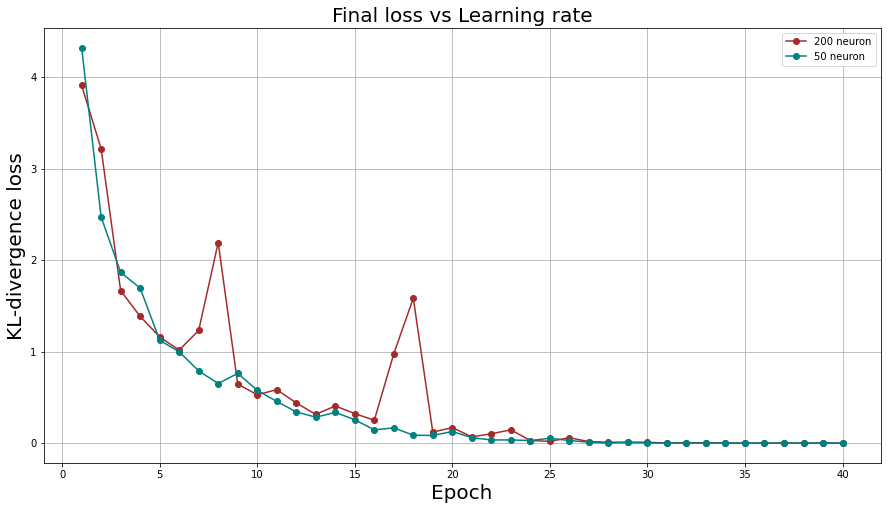

In [18]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,41), losses112, marker='o', c='brown', linestyle='-', label='200 neuron')
plt.plot(np.arange(1,41), losses113, marker='o', c='teal', linestyle='-', label='50 neuron')
plt.xlabel('Epoch', size=20)
plt.ylabel('KL-divergence loss', size=20)
plt.title('Final loss vs Learning rate', size=20)
plt.grid()
plt.legend()

From the plot we can see that the MLP converged in both 200 hidden neurons and 50 hidden neurons cases.

However, the MLP with 50 hidden neurons seems to converge slightly faster than the MLP with 200 hidden neurons, as well as less explosion in loss. One possible reason for this is MLP with 50 hidden neurons is simplier, with less weights and bias to be adjusted, resulting to a faster converged MLP, as well as more stable.

Now let us compare the accuracy on training and test sets.

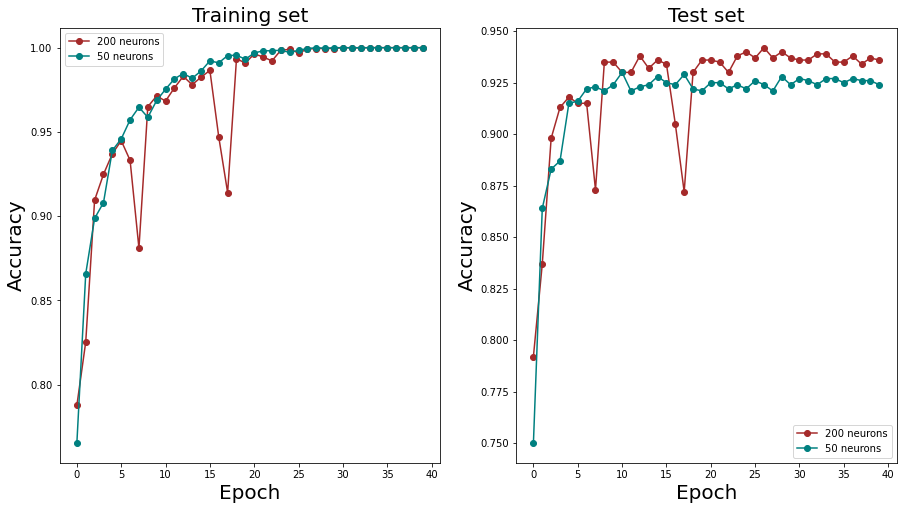

-------------Accuracy of trained model-------------
Accuracy on train set (hidden neuron = 200) is 1.0
Accuracy on train set (hidden neuron = 50) is 1.0

Accuracy on test set (hidden neuron = 200) is 0.936
Accuracy on test set (hidden neuron = 50) is 0.924


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))

ax1.plot(range(40), accuracy_train112, c='brown', marker='o', linestyle='-', label = '200 neurons')
ax1.plot(range(40), accuracy_train113, c='teal', marker='o', linestyle='-', label = '50 neurons')
ax1.set_xlabel('Epoch', size=20)
ax1.set_ylabel('Accuracy', size=20)
ax1.set_title('Training set', size=20)

ax2.plot(range(40), accuracy_test112, c='brown', marker='o', linestyle='-', label = '200 neurons')
ax2.plot(range(40), accuracy_test113, c='teal', marker='o', linestyle='-', label = '50 neurons')
ax2.set_xlabel('Epoch',size=20)
ax2.set_ylabel('Accuracy', size=20)
ax2.set_title('Test set', size=20)

ax1.legend()
ax2.legend()
plt.show()

print("-------------Accuracy of trained model-------------")
print(f'Accuracy on train set (hidden neuron = 200) is {accuracy_train112[-1]}')
print(f'Accuracy on train set (hidden neuron = 50) is {accuracy_train113[-1]}')

print(f'\nAccuracy on test set (hidden neuron = 200) is {accuracy_test112[-1]}')
print(f'Accuracy on test set (hidden neuron = 50) is {accuracy_test113[-1]}')

We can see that both MLP achieves $1.0$ accuracy on training set, this can be expected because in the previous loss picture, both MLP reaches to $0$ KL-loss in the end. 

However, from the output message, it can be told that on the test set, the MLP with 200 hidden neurons outperforms the MLP with 50 neurons in accuracy by $0.01$. 

Another difference that is worth noticing is that, on the training set, accuracy of 200-hidden-neuron model increases in a slightly slower pace compared to the 50-hidden-neuron model.

To understand such differences, we need to first understand how numbers of hidden neurons affects the model. Using more hidden neurons means there are more weights and bias need to be tuned. It is a more complex model and able to capture more intricate patterns in the dataset. Thus, it takes more time to learn the training set, resulting a slower increasing accuracy. However, as it discovers more pattern and details of the training set, it usually has a better generalisation to the unseen set. This is why after 10ish epochs, on the unseen test set, the accuray of MLP using 200 neurons starts to outperform the accuracy of MLP with 50 neurons.

But the difference in accuracy is not large, it could be due to 200 neurons are still not large enough considering we are having 784 pixels, or our dataset is not that inter-complicate and 50 neurons can complete the prediction task well.

###### 1.1.4

In this task, I introduce a dropout into the MLP training stage.

With dropout rate being 0.2, which means setting each neuron in each hidden layer to zero with probability 0.2.

Here is a function to generate a bernoulli boolean vector.

In [20]:
def dropout(n, rate=0.2):
    return np.random.binomial(1, (1 - rate), size = n)

For simiplicity, I write a new function to inplement the drop out. And now I will explain how I implement the dropout.

Start from the first post-activated hidden layer $h^{(1)}$ to the last post-activated hidden layer $h^{(3)}$, I will rescale each by $\frac{1}{1-\text{rate}}$ to compensate for the dropout during training.

Regarding the dropout, by the lecture notes, 'zero out' neurons is equivalent to 'zero out' weight connections. Thus I am randomly choosing some rows of $W^k \in \mathbb{R}^{n_k \times n_{k+1}}$, which is the weight matrix mapping neurons in layer $k$ to layer $k+1$, to be zero. In lecture note, this step is done by zero out columns, but its definition of $W$ is actually the transpose of our $W$, that is why I choose to take out rows. This step applies to $W1, W2, W3$ but not $W0$, otherwise we are not including all the data points into training.

The error terms and backpropagation process are not influenced by the dropout, but for the updation part, only the weights of non-zero neurons are updated.

In [21]:
def sgd_mlp_dropout(X, y, learning_rate, batch_size=128, epoches=90, hidden_neuron=200, 
                    output_neuron=10, dropout_rate=0.2, Xtest=None, ytest=None, param=False):
    """
    This function use stochastic gradient descent to train a multi-layer perceptron by introducing
    a dropout during training stage.

    :param X: 2d array, MNIST training set
    :param y: 1d array, training labels
    :param learning_rate: float, learning rate of gradient descent
    :param batch_size: int, size of each minibatch in SGD
    :param epoches: int, number of epoches we used to train the MLP
    :param hidden_neuron: int, number of neurons of hidden layer
    :param output_neuron: int, number of neurons of output layer
    :param Xtest: boolean, 2d array, MNIST test set
    :param ytest: boolean, 1d array, test labels
    :param param: boolean, whether return trained weights and bias

    :return losses: 1d array, KL loss of each epoch
    :return accuracy_train/accuracy_test: float, accuracy of prediction on training/test set
    :return Ws, bs: 2d/1d array, trained weights and bias
    """
    #Initialisation
    losses = np.zeros(epoches)
    accuracy_train = np.zeros(epoches)
    accuracy_test = np.zeros(epoches)

    # Glorot initialisation for weights and bias
    W0, b0, W1, b1, W2, b2, W3, b3 = Glorot_initial(X.shape[1], hidden_neuron,
                                                   output_neuron)

    # Batches for sgd
    indices = np.arange(X.shape[0])
    batch_num = np.ceil(X.shape[0] / batch_size).astype(int)

    for epoch in range(epoches):
        # Shuffle at each epoch
        np.random.shuffle(indices)
        # Iterate through each batch
        for i in range(batch_num):
            batch_idx = indices[i*batch_size:(i+1)*batch_size]
            X_b, y_b = X[batch_idx], y[batch_idx]
            
            # first hidden layer
            #dp0 = dropout(W0.shape[1], dropout_rate) # dropout
            a1 = dense(X_b, W0, b0)
            h1 = softplus(a1)
            h1 *= 1 / (1 - dropout_rate) # scale output
            
            # second hidden layer
            dp1 = dropout(W1.shape[0], dropout_rate).reshape(-1,1) # dropout
            a2 = dense(h1, dp1*W1, b1)
            h2 = softplus(a2)
            h2 *= 1 / (1 - dropout_rate) # scale output
            
            # third hidden layer
            dp2 = dropout(W2.shape[0], dropout_rate).reshape(-1,1) # dropout
            a3 = dense(h2, dp2*W2, b2)
            h3 = softplus(a3)
            h3 *= 1 / (1 - dropout_rate) # scale output
            
            # output layer
            dp3 = dropout(W3.shape[0], dropout_rate).reshape(-1,1)
            a4 = dense(h3, dp3*W3, b3)
            h4 = softmax(a4)
        
            # Backpropagating to find all the errors
            delta4 = output_error(np.eye(10)[y_b], h4)

            delta3 = backpropagate(delta4, W3, a3)

            delta2 = backpropagate(delta3, W2, a2)
            
            delta1 = backpropagate(delta2, W1, a1)
    
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 =\
            grads(delta1, delta2, delta3, delta4, X_b, h1, h2, h3)
    
            W0 -= learning_rate * (grad_W0.T)
            b0 -= learning_rate * grad_b0
            
            W1 -= learning_rate * (dp1 * grad_W1.T)
            b1 -= learning_rate * grad_b1
            
            W2 -= learning_rate * (dp2 * grad_W2.T)
            b2 -= learning_rate * grad_b2
            
            W3 -= learning_rate * (dp3 * grad_W3.T)
            b3 -= learning_rate * grad_b3

        # Print our training progress
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} is completed.")
        
        # Analysis
        y_pred, accuracy_train[epoch] = predict_accuracy(X, y, W0, b0, W1, b1, W2, b2, W3, b3)
        # One-hot encoding, KL-loss on training set
        losses[epoch] = KL_loss(np.eye(10)[y], np.eye(10)[y_pred])
        
        if Xtest is not None:
            # Accuracy of prediction on test set
            _, accuracy_test[epoch] = predict_accuracy(Xtest, ytest, W0, b0, W1, b1, W2, b2, W3, b3)
    
    if Xtest is not None:
        return losses, accuracy_train, accuracy_test
    elif param:
        return W0, b0, W1, b1, W2, b2, W3, b3
    else:
        return losses

Base on the hint provided in the coursework, I am using a larger number of epoches of $90$ to train the MLP with dropout. 

Instead of grid searching for new learning rate, let us proceed with previous optimal learning $0.1$, and see whether the KL-loss converges.

Here we compare the loss and accuracy of MLP with dropout to results without dropout obtained in 1.1.2.

In [22]:
# Train the model with dropout
losses_dropout, accuracy_train_dropout, accuracy_test_dropout = sgd_mlp_dropout(
    Xmnist_train_std, ymnist_train, learning_rate=0.1, epoches=90, Xtest=Xmnist_test_std, ytest=ymnist_test)

Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
Epoch 50 is completed.
Epoch 60 is completed.
Epoch 70 is completed.
Epoch 80 is completed.
Epoch 90 is completed.


-------------Final KL loss-------------
Without dropout is 0.0
With dropout is 0.06754249609782535


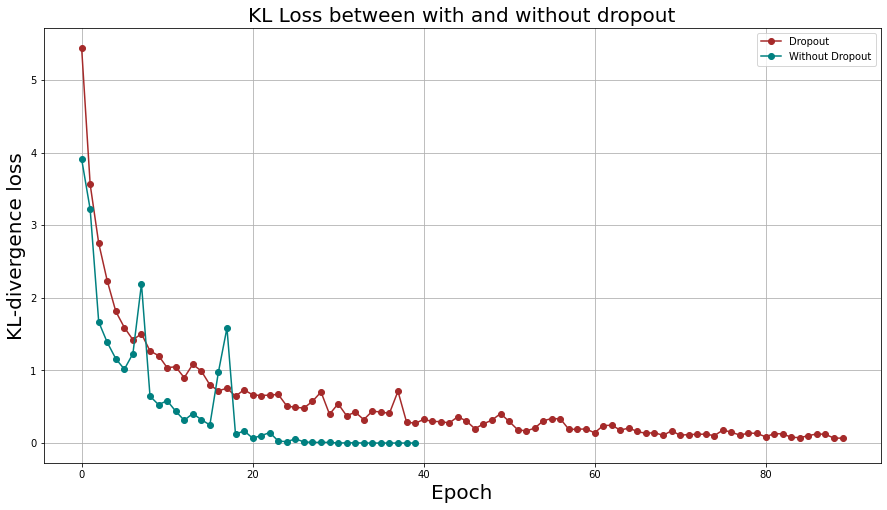

In [23]:
plt.figure(figsize=(15,8))
plt.plot(losses_dropout, marker='o', linestyle='-', c='brown', label='Dropout')
plt.plot(losses112, marker='o', linestyle='-', c='teal', label='Without Dropout')
plt.xlabel('Epoch', size=20)
plt.ylabel('KL-divergence loss', size=20)
plt.title('KL Loss between with and without dropout', size=20)
plt.grid()
plt.legend()

print("-------------Final KL loss-------------")
print(f'Without dropout is {losses112[-1]}')
print(f'With dropout is {losses_dropout[-1]}')

We can see that adding dropout to the training stage will slow down the decrease of KL-divergence loss. This is expected as some neurons are removed, and MLP takes more time, more epochs to learn the dataset. The final KL-loss converges to a small value of 0.07. Although not exactly zero and with some small fluctuation, it is acceptable as dropout increases randomness. 0.07 shows our MLP does well in reducing the loss and using 0.1 as learning rate is reasonable.

Now let us see its performace in accuracy.

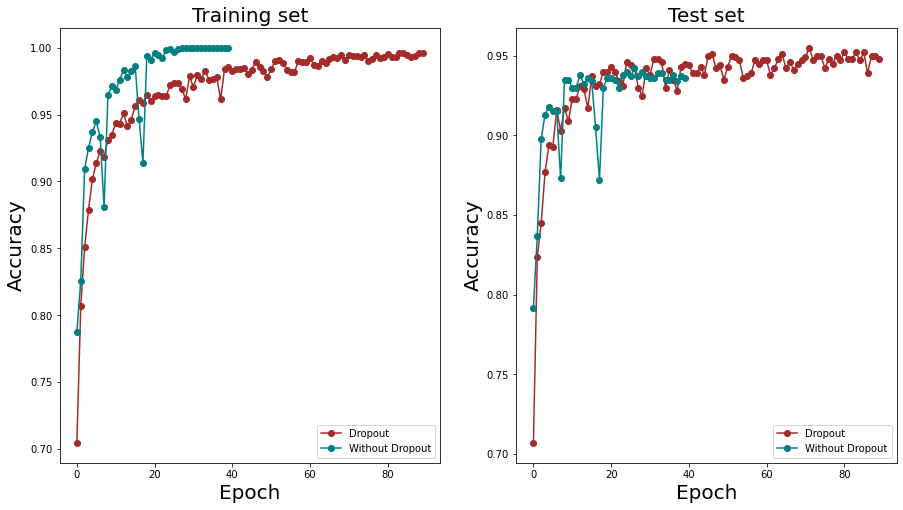

-------------Accuracy on training set-------------
Without dropout is 1.0
With dropout is 0.9963333333333333

-------------Accuracy on test set-------------
Without dropout is 0.936
With dropout is 0.948


In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))

ax1.plot(range(90), accuracy_train_dropout, c='brown', marker='o', linestyle='-', label = 'Dropout')
ax1.plot(range(40), accuracy_train112, c='teal', marker='o', linestyle='-', label = 'Without Dropout')
ax1.set_xlabel('Epoch', size=20)
ax1.set_ylabel('Accuracy', size=20)
ax1.set_title('Training set', size=20)

ax2.plot(range(90), accuracy_test_dropout, c='brown', marker='o', linestyle='-', label = 'Dropout')
ax2.plot(range(40), accuracy_test112, c='teal', marker='o', linestyle='-', label = 'Without Dropout')
ax2.set_xlabel('Epoch',size=20)
ax2.set_ylabel('Accuracy', size=20)
ax2.set_title('Test set', size=20)

ax1.legend()
ax2.legend()
#plt.suptitle('Accuracy vs Epochs for hidden neuron = 200 and 50', size=20)
plt.show()

print("-------------Accuracy on training set-------------")
print(f'Without dropout is {accuracy_train112[-1]}')
print(f'With dropout is {accuracy_train_dropout[-1]}')

print("\n-------------Accuracy on test set-------------")
print(f'Without dropout is {accuracy_test112[-1]}')
print(f'With dropout is {accuracy_test_dropout[-1]}')

We can see from the training set that, the accuracy of dropout is increasing slower than that without dropout. This aligns with the trend of losses we just looked at. This could be because dropout acts as a regularization technique, effectively "thinning" the network by randomly disabling neurons during training. As a result, the model is forced to learn more robust and generalizable features, preventing overfitting in a slower way consequently.
Eventually the accuracy of dropout reaches 0.996. It is a very high score, showing that even under dropping out, the MLP learns our traning dataset well. It is slightly lower than accuracy of without dropping out on training set, but it is expected, as the non-dropout model is prone to overfitting and tends to perform better on the training data

We now focus on the performace on test set. In this case, accuracy of MLP using dropout is increasing in a similar pace with MLP not using dropout. And it even reaches a higher accuracy (0.948 compared to 0.936) in the end. This indicates that the dropout regularization technique helps improve the generalization capabilities of the MLP. This again aligns with the effectiveness of dropout as a regularization technique for improving the generalization performance of an MLP.

By looking at the plot, around epoch 70, accuracy can be even higher. This observation may suggest that early stopping could be applied to prevent overfitting and achieve better test set performance. 

Last but not least, let us visualise the histograms of the activations of the units in the first hidden layer. First, we get the weight and bias use to generate the first pre-activation layer.

In [25]:
# Train data first
# Without dropout
W0_without, b0_without = sgd_mlp(Xmnist_train_std, ymnist_train, learning_rate=0.1, 
                                param=True)[:2]
# With dropout
W0_with, b0_with = sgd_mlp_dropout(Xmnist_train_std, ymnist_train, learning_rate=0.1, 
                                epoches=90, param=True)[:2]

Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
Epoch 10 is completed.
Epoch 20 is completed.
Epoch 30 is completed.
Epoch 40 is completed.
Epoch 50 is completed.
Epoch 60 is completed.
Epoch 70 is completed.
Epoch 80 is completed.
Epoch 90 is completed.


Now, let us first randomly select a batch of test set with size 128. And we propoagate it to get its firts hidden layer for dropout and without dropout respectively.

Notice that the dropout is not on test set here by answers on Ed forum. Also, as I have compensated hidden layers during training, there is no point to compensate them again here.

Text(0, 0.5, 'Density')

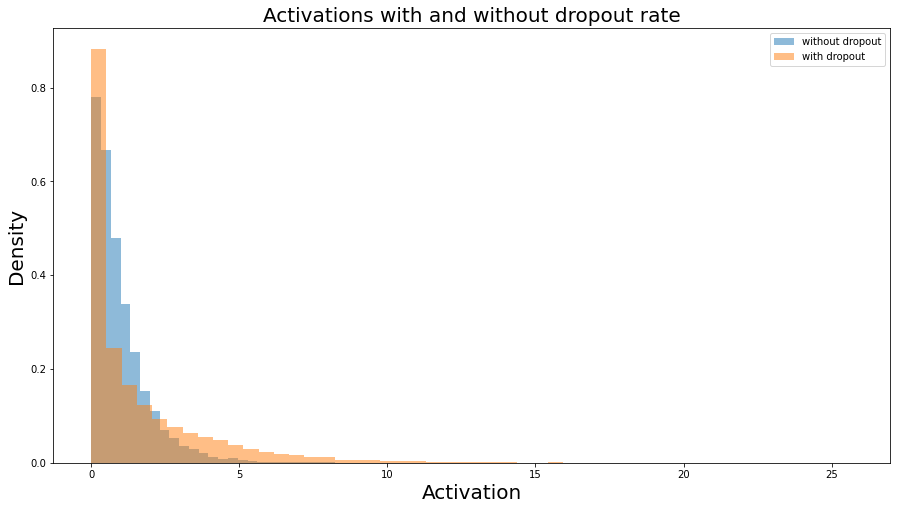

In [26]:
# Randomly select a batch of size 128
Xtest114 = Xmnist_test_std.copy()
np.random.shuffle(Xtest114)
X_batch = Xtest114[:128]

#Without dropout
a1_without = dense(X_batch, W0_without, b0_without)
h1_without = softplus(a1_without)

#With dropout
a1_with = dense(X_batch, W0_with, b0_with)
h1_with = softplus(a1_with)

plt.figure(figsize=(15,8))
plt.hist(h1_without.flatten(), label = 'without dropout', bins=50, alpha = 0.5, density=True)
plt.hist(h1_with.flatten(), label = 'with dropout', bins=50, alpha = 0.5, density=True)
plt.legend()
plt.title('Activations with and without dropout rate', size=20)
plt.xlabel('Activation', size=20)
plt.ylabel('Density', size=20)

From the figure, we can see two main things: 

1. Density mostly around zeros: In both cases, the activation density is primarily concentrated around zero. This indicates that many neurons in the hidden layers have low or no activation, potentially leading to sparse activations within the network. MLP with dropout has more values around zero values, because we are zeroing out some neurons during training, and the consequence reflects here.

2. Dropout has a wider and sparser distribution of activation density: When dropout is applied during training, the distribution of activation density becomes wider and sparser compared to the MLP without dropout. More neurons are having greater activations, this could be resulted by our compensation of multiplier $\frac{1}{1-\text{rate}}$ during the training. This result suggests that dropout encourages the network to learn a more diverse set of features and rely on different subsets of neurons during training. By randomly dropping out neurons during training, the model is forced to learn redundant representations, which can improve the model's robustness and generalization performance. The benefits can be seen from the fact that MLP with dropout outperformed MLP without dropout in accuracy on unseen testset. 

#### 1.2 Dimensionality reduction (20 marks)

###### 1.2.1

In this task, I will work on two image datasets that is corrupted by noise.

Let us firstly load the datasets and perform standard validaity checks to them.



In [27]:
Xmnist_noisy_train = np.loadtxt('MNIST_train_noisy.txt')
Xmnist_noisy_test = np.loadtxt('MNIST_test_noisy.txt')

print('--------------Validaity check for training set--------------')
print("---Check for numerical columns (without 'Type' column)---")
print(np.all([np.issubdtype(Xmnist_noisy_train[:, i].dtype, np.number) for i in range(Xmnist_noisy_train.shape[1])]))
print("---Check for Inf/NaN (All columns)---")
print(np.any(np.isinf(Xmnist_noisy_train)) or np.any(np.isnan(Xmnist_noisy_train)))

print('--------------Validaity check for test set--------------')
print("---Check for numerical columns (without 'Type' column)---")
print(np.all([np.issubdtype(Xmnist_noisy_test[:, i].dtype, np.number) for i in range(Xmnist_noisy_test.shape[1])]))
print("---Check for Inf/NaN (All columns)---")
print(np.any(np.isinf(Xmnist_noisy_test)) or np.any(np.isnan(Xmnist_noisy_test)))

--------------Validaity check for training set--------------
---Check for numerical columns (without 'Type' column)---
True
---Check for Inf/NaN (All columns)---
False
--------------Validaity check for test set--------------
---Check for numerical columns (without 'Type' column)---
True
---Check for Inf/NaN (All columns)---
False


From the output message, we can tell both datasets are all numerical and not having any invalid (Inf/NaN) values. We are good to proceed with them directly.

By convention, let us standardise our descriptor set first. Notice that here I choose to standardise only using mean and variance of the training set.

In [28]:
## Data standardisation
Xmnist_noisy_train01 = Xmnist_noisy_train/255.
Xmnist_noisy_std_train = standardise(Xmnist_noisy_train01) 

Xmnist_noisy_test01 = Xmnist_noisy_test/255.
Xmnist_noisy_std_test = standardise(Xmnist_noisy_train01, Xmnist_noisy_test01)

To perform the principal component analysis carrying out dimensionality reduction, I define the following function to, given orginal matrix $X$, generate rank-$m$ approximation matrix, first $m$ principal components of $X$ and corresponding eigenvalues.

In [29]:
def PCA(X, m):
    """
    This function performs Principal Component Analysis (PCA) on the input data X, reducing its dimensionality
    to m principal components.
    
    :param X: 2d array, representing the input data points
    :param m: int, the number of principal components to retain

    :return X_pca: 2d array, the transformed data with reduced dimensionality
    :return eigenvectors: 2d array, the first m principal components
    :return eigenvalues: 1d array, the m largest eigenvalues of the covariance matrix
    """
    # Compute the covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute all eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(C)
    
    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index][:m]
    eigenvectors=eigenvectors[:,sorted_index ][:,:m]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

By definition, the total variance explained by the data with rank $p$ is defined as 
$$
V = \sum_{i=1}^p \lambda_i
$$
where $\lambda_i$ is the eigenvalue of covariance matrix of the data. And the fraction explained (explained variance ratio) by the first $m$ principal components is defined as 
$$
\frac{\sum_{i=1}^m \lambda_i}{V}
$$
Next I will examine the fraction explained from $m=1$ to $m=p$ where $m=p$ is the rank of our correlation matrix.

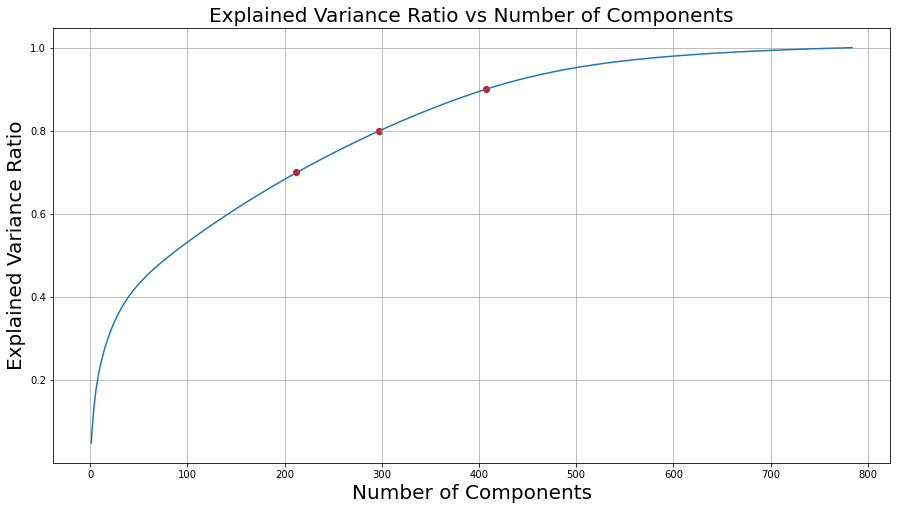

------------------------------------------------------------------
Number of components for 70% variance explained:  213
Number of components for 80% variance explained:  298
Number of components for 90% variance explained:  408


In [30]:
# set m to be the maximum value
m = Xmnist_noisy_std_train.shape[1]
# PCA of all principal components
Xpca, eigenvectors, eigenvalues = PCA(Xmnist_noisy_std_train, m)
# Total variance
total_variance = abs(eigenvalues.sum())

# Fraction explained from different m
explained_variances = np.zeros(m)
for i in range(m):
    explained_variances[i] = eigenvalues[:i+1].sum() / total_variance

# Find the index of the first element that is greater than or equal to 0.7, 0.8 and 0.9
idx_70 = next(i for i, explained_variance in enumerate(explained_variances) if explained_variance >= 0.7)
idx_80 = next(i for i, explained_variance in enumerate(explained_variances) if explained_variance >= 0.8)
idx_90 = next(i for i, explained_variance in enumerate(explained_variances) if explained_variance >= 0.9)

# Plot the graph and mark the points with red dots
plt.figure(figsize=(15,8))
plt.plot(np.arange(1, m+1), explained_variances)
plt.scatter(idx_70, 0.7, c='r')
plt.scatter(idx_80, 0.8, c='r')
plt.scatter(idx_90, 0.9, c='r')
plt.xlabel('Number of Components', size=20)
plt.ylabel('Explained Variance Ratio', size=20)
plt.title('Explained Variance Ratio vs Number of Components', size=20)
plt.grid()
plt.show()

print("------------------------------------------------------------------")
print("Number of components for 70% variance explained: ", idx_70+1)
print("Number of components for 80% variance explained: ", idx_80+1)
print("Number of components for 90% variance explained: ", idx_90+1)

From the output figure, it can be seen that the explained variance ratio is monotonically increasing to $1$ when all the components are used. 

First 213 components explain 70% variance, first 298 components explain 80% variance, and first 408 components explain 90% variance.

Next let us viualise the first 10 princial components from PCA.

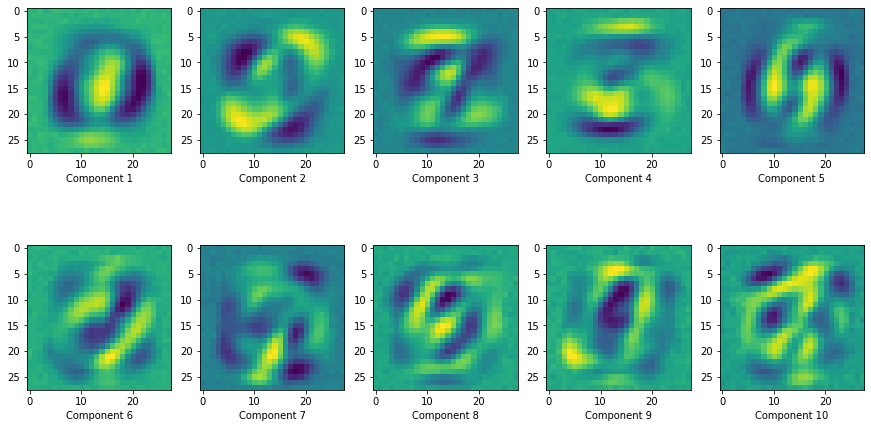

In [31]:
Xpca_121, eigenvectors_121, eigenvalues_121 = PCA(Xmnist_noisy_std_train, m=10)

nrow = 2; ncol = 5
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,8))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors_121[:,i].reshape([28,28]))
    ax.set_xlabel(f"Component {str(i+1)}")

###### 1.2.2

Before applying the Non-negative matrix factorisation (NMF), we must ensure our objective matrix does not contain any negative values. The standardise function used before will sometimes produce negative values, therefore, instead now we perform the min-max normalisation. It will scale the input data into $[0, 1]$. It ensures every image has same scale without any negative values.

Same as standarisation function, normalisation function is implemented with a 'revert' method, to recale the normalised dataset back to its original scale.

In [32]:
def normalize_nmf(X, Xrevert=None):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))

    if Xrevert is not None:
        X_norm = Xrevert * (np.max(X) - np.min(X)) + np.min(X)
    return X_norm

Unlike standardisation, here I normalise train set and test set using their own minimum annd maximum individually. 

In [33]:
# Data Normalisation
Xmnist_noisy_normal_train = normalize_nmf(Xmnist_noisy_train01)
Xmnist_noisy_normal_test = normalize_nmf(Xmnist_noisy_test01) 

To perform the NMF, we are essentially trying to find $W$ and $H$ such that 
$$
X \approx WH
$$
and for $d = X - WH$ and $n$ being total number of entries in $X$,
$$
\chi^2 = \frac{e^T(X * d * d)e}{n}
$$
is converged to a minimum.

In [34]:
def cost(X, W, H):
    """
    This function calculates the difference between X and WH where W and H are factorised through NMF.
    
    :param X: (N x p) 2d array, input data
    :param W: (N x r) 2d array, non-negative coefficients expressing X in the basis of vectors in H
    :param H: (r x p) 2d array, non-negative equivalent of the principal components
    
    :return cost_value: float, square of the Euclidean distance between X and WH
    """
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)
    # Compute the Euclidean distance-based objective function
    cost_value = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return cost_value

Now let us implement Lee and Seung's multiplicative update rule to compute the factorisation.

In [35]:
def NMF(X, m, iteration, pseudo_count=0.001, converge_check=False):
    """
    This function perform NMF based on Lee and Seung's multiplicative update rule.
    
    :param X: 2d array, represent the input data
    :param m: int, represent number of principal component
    :param pseudo_count: float, small value added to zero
    :param converge_check: boolean variable, whether output the convergence message
    
    :return W: 2d array, non-negative coefficients expressing X in the basis of vectors in H
    :return H: 2d array, non-negative equivalent of the principal components
    :return cost_value: float, || X - WH ||^2
    """
    
    np.random.seed(0) # random seed

    # k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
    H = np.random.rand(m, X.shape[1])

    # N x k components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], m)

    # empty list 
    cost_values = []

    # loop over the n iterations
    for i in range(iteration):

        # compute the update on H
        H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))

        # compute the update on W
        W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) 

        # compute the cost and append to list
        cost_values.append(cost(X,W,H))
    
    # A throughout convergence check
    if converge_check:
        convergence_threshold, convergence_index = 1e-6, -1
        converged = False
        # Find the first convergence point
        for i in range(1, len(cost_values)):
            if abs(cost_values[i] - cost_values[i - 1]) < convergence_threshold:
                converged = True
                convergence_index = i
                break
        # Check if the cost stays converged after the first convergence point
        if converged:
            for i in range(convergence_index + 1, len(cost_values)):
                if abs(cost_values[i] - cost_values[i - 1]) >= convergence_threshold:
                    converged = False
                    break
        if converged:
            print(f"Loss converged for the first time at iteration {convergence_index} and remained converged.")
        else:
            if convergence_index != -1:
                print(f"Loss converged for the first time at iteration {convergence_index}, but it did not remain converged.")
            else:
                print("Loss never converged.")
    
    return W, H, cost_values, convergence_index

Now I perform the NMF, with first 10 principal components onto which to project the data.

In [36]:
W, H, cost_values, idx = NMF(Xmnist_noisy_normal_train, m=10, iteration=2000, converge_check=True)

Loss converged for the first time at iteration 179 and remained converged.


From the output message, we can tell at threshold $1e-6$, the cost is converged at iteration $179$, which is less than out maximum iteration $500$. It then remained converged in the future iteration. To confirm this, let us plot the loss function against iteration.

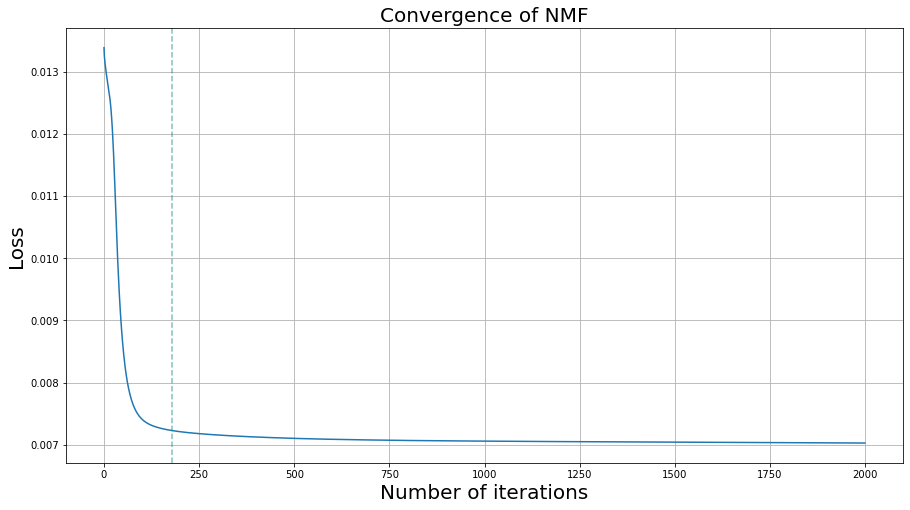

In [37]:
plt.figure(figsize=(15,8))
plt.plot(cost_values)
plt.axvline(x=idx, color='gray', alpha=0.5, linestyle='--', c='teal')
plt.title('Convergence of NMF', size=20)
plt.xlabel('Number of iterations', size=20)
plt.ylabel('Loss', size=20)
plt.grid()
plt.show()

This can be confirmed by our figure above as well, and for all iterations after $179$, the loss is still decreasing a bit, but the each after each iteration is than our threshol, thus we take it as a convergence. It shows our max iteration is enough.

We now viualise the first 10 non-negative principal components of NMF.

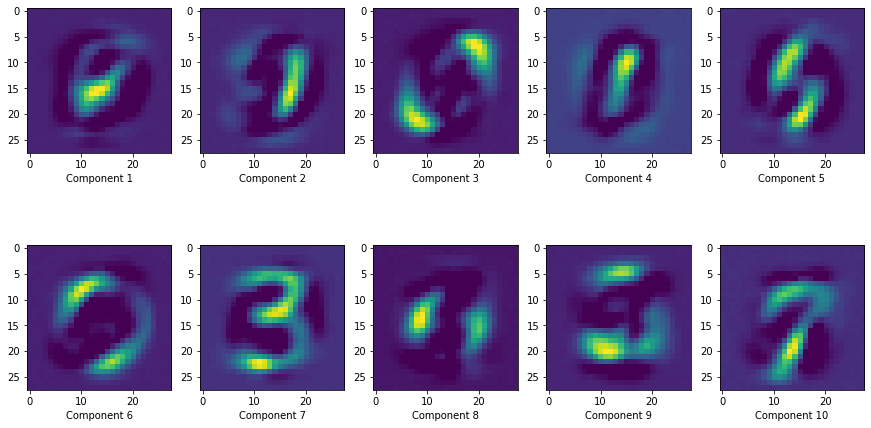

In [38]:
fig, axs = plt.subplots(2, 5,figsize=(15,8))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i].reshape([28,28]))
    ax.set_xlabel(f"Component {str(i+1)}")

To compare the NMF and PCA components, let us plot them alongside each other.

The first and second rows contain the first five components from PCA and NMF respectively; the third and fourth rows contain the seconf five components from PCA and NMF respectively.

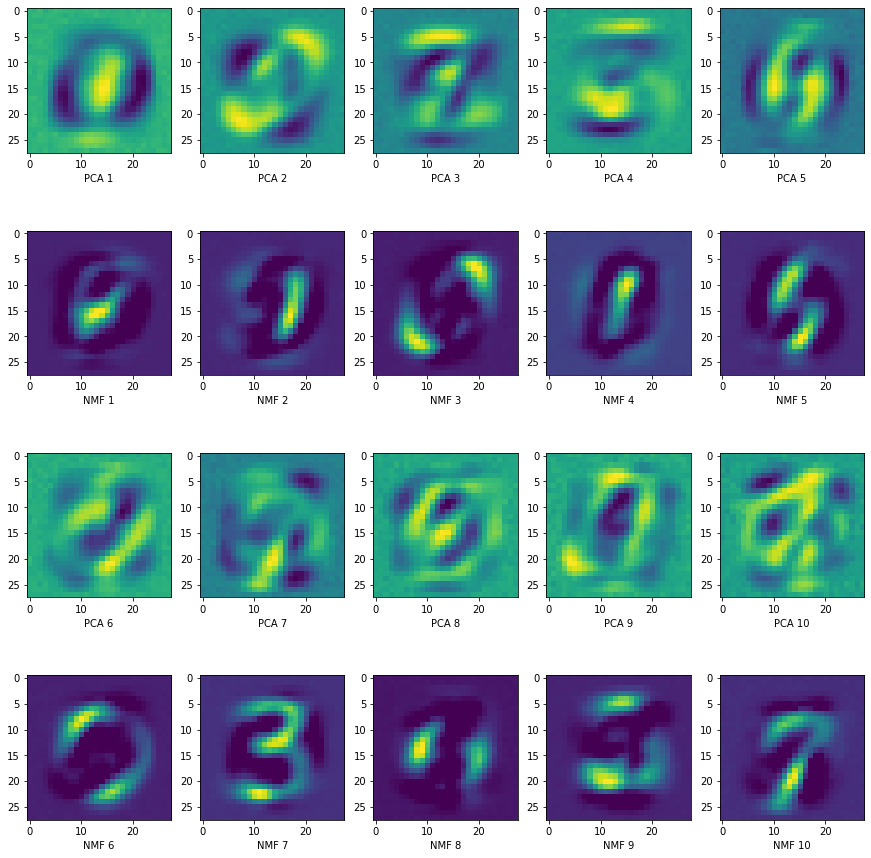

In [39]:
fig, axs = plt.subplots(4, 5, figsize=(15, 15))

for i, ax in enumerate(axs.reshape(-1)):
    row = i // ncol
    col = i % ncol

    if row % 2 == 0:  # First and third rows
        image = eigenvectors_121[:, col + row * ncol // 2].reshape([28, 28])
        label = f"PCA {col + 1 + row * ncol // 2}"
    else:  # Second and fourth rows
        image = H[col + (row - 1) * ncol // 2].reshape([28, 28])
        label = f"NMF {col + 1 + (row - 1) * ncol // 2}"

    ax.imshow(image)
    ax.set_xlabel(label)

# Increase the interval between rows
fig.subplots_adjust(hspace=0.5)
plt.show()

Differences:
1. From the plot above, we can immediately see that components of NMF capture the colour of purple, while components of PCA demonstrate mostly green. 

2. Meanwhile, it seems that components of NMF capture less noises than components of PCA do. 

3. Furthermore, corresponding components are not explaining the exactly same thing. For example, 'PCA 3' and 'NMF 3', 'PCA 4' and 'NMF 4' are clearly showing different details.

The color differences are mainly caused by PCA components have both positive and negative values, which can lead to a mix of colors when visualised. On the other hand, NMF enforces non-negativity constraints on its components, resulting in the absence of negative values. This difference in values can be directly seen from the difference in color in heatmap.

PCA aims to capture more variances in its first few principal components. More variances means both signal and noise from our noisy training set are captured, which may lead to noisier visualizations. In contrast, this is not true for NMF, there is not a say that first few components captures the most variance. NMF tends to produce parts-based representations, capturing local patterns and structures in the data. As a result, NMF components often appear less noisy and more interpretable. This could also explain the third difference, components of NMF and PCA are representing different things, thus it is natural that some figures are showing differently.

###### 1.2.3

In this task, I will reconstruct images from noisy test set using first 100 components retrieved from PCA and NMF respectively on noisy training set, and compare the reconstructed one to the clean images.

Then let us begin with factorising out different components from PCA and NMF.

In [40]:
## PCA
Xpca, eigenvectors, eigenvalues = PCA(Xmnist_noisy_std_train, m=100)

# NMF
print("--------Convergence Reusult of NMF----------")
W, H, cost_values, _ = NMF(Xmnist_noisy_normal_train, m=100, iteration=2000, converge_check=True)

--------Convergence Reusult of NMF----------
Loss converged for the first time at iteration 342 and remained converged.


The output message suggests that our NMF algorithm has successfully converged befor reaching the maximum iteration, and remain converged.

Now we consider the reconstruction of image using PCA first 100 principal components:

Denote our (standardised) noisy test set as $X_{(n x p)}$ and the first $m$ principal components as $V_{(p x m)}$, where each column of $V$ contains one principal component. We then project $X_{(n x p)}$ onto the first $m$ principal components by
$$
Z_{(n x m )} = X_{(n x p)}V_{(p x m)}
$$
It reduces the dimensionality of $X_{(n x p)}$ from $p$ features to $m$ principal components, effectively projecting each test image onto the m-dimensional subspace spanned by the principal components.

To reconstruct the images, we map the projected samples back to the original p-dimensional feature space by computing
$$
\hat X_{(n x p)} = Z_{(n x m)}V^T_{(m x p)}
$$

Deonte each row of $\hat X_{(n x p)}$ as $x^{(i)}$, each entry of $Z_{(n x m)}$ as $z_{i,j}$. $V^T$ now contains each principal component in its row, so we denote each row as $PC_i$, we can write the above equation element-wise by
$$
x^{(i)} = z_{i,1}\cdot PC_1 + z_{i,2} \cdot PC_2 + z_{i,3} \cdot PC_3 + \cdots + z_{i,m} \cdot PC_m
$$
Therefore, each image can be written as a linear combination of the principal components. Now let us implement this algorithm, and viualise the final image reconstructed, compare it with the corresponding image in noisy test set and clean test set. 

I have recovered the reconstructed dataset to its original scale to compare with unstandardised clean/noisy image.

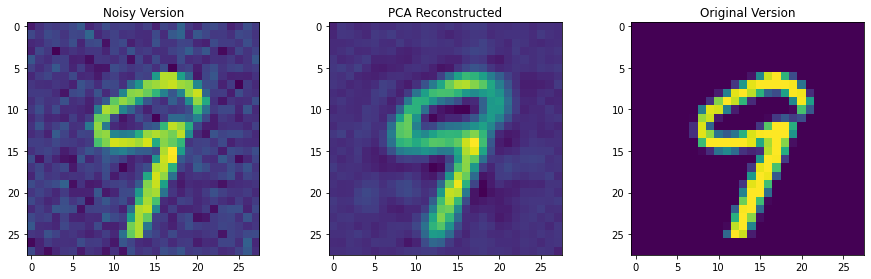

In [41]:
# PCA reconstruction
Z = Xmnist_noisy_std_test.dot(eigenvectors)
X_pca_reconstruct = Z.dot(eigenvectors.T)

# Multiply/add back variance and mean
X_pca_reconstruct = standardise(Xmnist_noisy_train01, Xrevert=X_pca_reconstruct)

# Visualisation
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
# noisy image (unstandardised)
axs[0].imshow(Xmnist_noisy_test01[50].reshape(28,28))
axs[0].set_title("Noisy Version")
# reconstructed image (unstandardised)
axs[1].imshow(X_pca_reconstruct[50].reshape(28,28))
axs[1].set_title("PCA Reconstructed")
# clean image (unstandardised)
axs[2].imshow(Xmnist_test_01[50].reshape(28,28))
axs[2].set_title("Original Version")
fig.subplots_adjust(wspace=0.3)
plt.show()

The reconstruction from NMF components is slightly different. As the non-negative components are not orthogonal to each other, we need another way to find the coefficient of the components.

As we are having the non-negative principal component matrix $H_{(mxp)}$ from training set, and let us still denote the test set as $X_{(n x p)}$, we want to find a coefficient matrix $B_{(n x m)}$ such that
$$
X_{(n x p)} \approx B_{(n x m)}H_{(mxp)}
$$
Likewise, as each row of $H$ is the non-negative component which is denoted as $H^{(i)}$, we can still write each row (image) in $X$ as a linear combination:
$$
x^{(i)} = B_{i,1}H^{(1)} + B_{i,2}H^{(2)}+ \cdots + B_{i,m}H^{(m)}
$$
Now let us use the Lee annd Seung's multiplicative update rule to find the optimal $B$.

In [42]:
def nmf_reconstruction(X, H, max_iter=1000, tol=1e-6):
    """
    This function finds the non-negative coefficients of the non-negative principal
    components of NMF by using Lee and Seung's multiplicative rule.
    
    :param X: 2d array, input data array
    :param H: 2d array, non-negative principal component from training set
    :param max_iter: int, maximum number of iteration for updating
    :param tol: float, tolerance for convergence of cost
    
    :return B: 2d array, non-negative coefficient 
    """
    n, p = X.shape
    m, _ = H.shape

    # Initialize b with random non-negative values
    b = np.random.rand(n, m)
    
    costs = np.zeros(max_iter)
    # Iteratively update b
    for i in range(max_iter):
        b_prev = b.copy()

        # Multiplicative update rules for NMF
        b *= (X @ H.T) / (b @ H @ H.T + 1e-3) # Add small constant to avoid division by zero
        
        costs[i] = cost(X, b, H)
        
    # A throughout convergence check
    convergence_threshold, convergence_index = 1e-6, -1
    converged = False
    # Find the first convergence point
    for i in range(1, len(costs)):
        if abs(costs[i] - costs[i - 1]) < convergence_threshold:
            converged = True
            convergence_index = i
            break
    # Check if the cost stays converged after the first convergence point
    if converged:
        for i in range(convergence_index + 1, len(costs)):
            if abs(costs[i] - costs[i - 1]) >= convergence_threshold:
                converged = False
                break
    if converged:
        print(f"Loss converged for the first time at iteration {convergence_index} and remained converged.")
    else:
        if convergence_index != -1:
            print(f"Loss converged for the first time at iteration {convergence_index}, but it did not remain converged.")
        else:
            print("Loss never converged.")

    return b, costs, convergence_index

Loss converged for the first time at iteration 67 and remained converged.


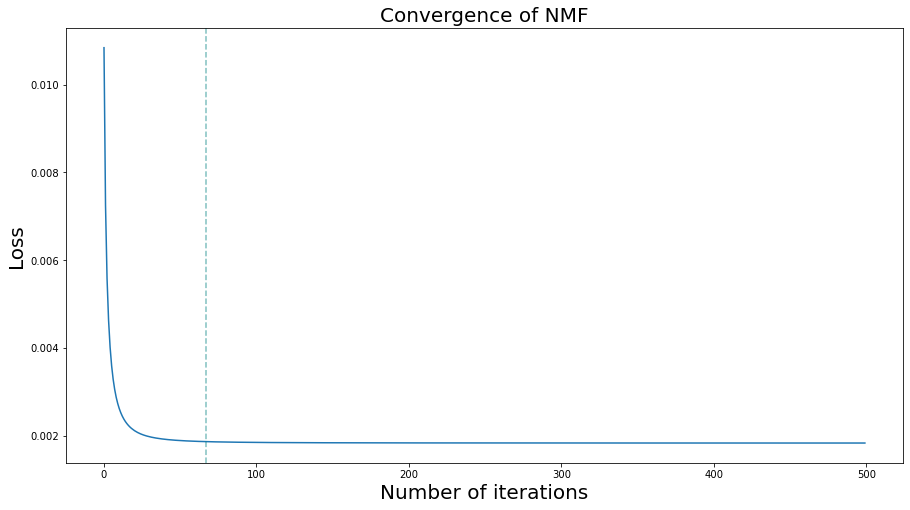

In [43]:
B, costs_reconstruct, idx = nmf_reconstruction(Xmnist_noisy_normal_test, H, max_iter=500)

plt.figure(figsize=(15,8))
plt.plot(costs_reconstruct)
plt.axvline(x=idx, color='gray', alpha=0.5, linestyle='--', c='teal')
plt.title('Convergence of NMF', size=20)
plt.xlabel('Number of iterations', size=20)
plt.ylabel('Loss', size=20)
plt.show()

From the figure we can see that the loss only used 67 iteration to converge to a loss of around 0.002 and remain converged. Thus our iterative updation is valid for finding an optimal $B$.

Now we can re-construct our images by 
$$
\hat X = BH
$$

In [44]:
X_nmf_reconstruct = B @ H

print("The minimum entry in coefficient matrix B is: ", B.min())
print("The minimum entry in reconstructed matrix X is: ", X_nmf_reconstruct.min())

The minimum entry in coefficient matrix B is:  1.4979553274289462e-55
The minimum entry in reconstructed matrix X is:  0.04816043763468419


To check our coefficient matrix and reconstruct matrix are valid, I print out the minimum entry in both matrices, and we can see those two values are both positive. Thus we are ensured that our non-negativity constraint is maintained. 

To compare with original images, as usual, I will re-scale our newly constructed images beforehand.

In [45]:
X_nmf_reconstruct = normalize_nmf(Xmnist_noisy_test01, Xrevert=X_nmf_reconstruct)

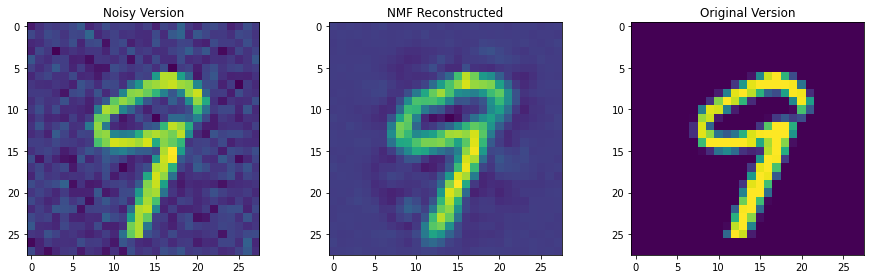

In [46]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

# plot the original image in the first subplot
axs[0].imshow(Xmnist_noisy_test01[50].reshape(28,28))
axs[0].set_title("Noisy Version")

# plot the reconstructed image in the second subplot
axs[1].imshow(X_nmf_reconstruct[50].reshape(28,28))
axs[1].set_title("NMF Reconstructed")

axs[2].imshow(Xmnist_test_01[50].reshape(28,28))
axs[2].set_title("Original Version")

# add space between the subplots
fig.subplots_adjust(wspace=0.3)

# display the plot
plt.show()

We can see that the NMF is doing an incredible job in denoising, with much any noise remains.

Before interpreting the reasons behind the reconstruction, let us viualise the PCA and NMF recovered picture together.

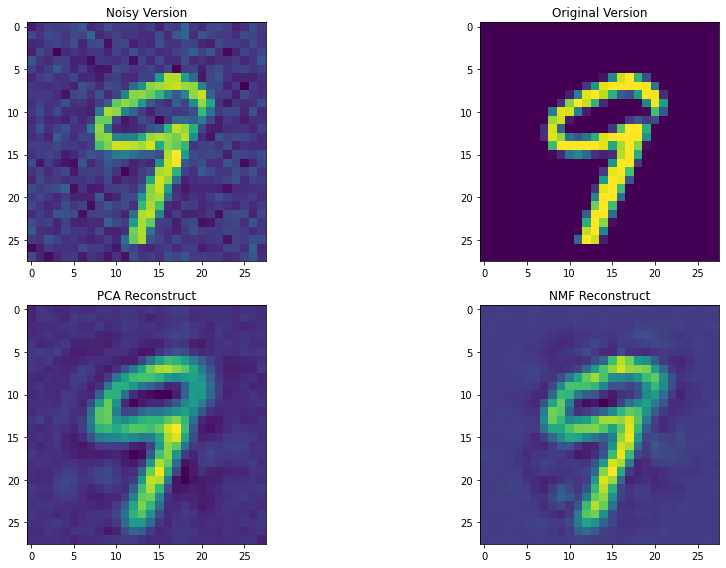

In [47]:
# create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

axs[0,0].imshow(Xmnist_noisy_test01[50].reshape(28,28))
axs[0,0].set_title("Noisy Version")

axs[0,1].imshow(Xmnist_test_01[50].reshape(28,28))
axs[0,1].set_title("Original Version")

axs[1,0].imshow(X_pca_reconstruct[50].reshape(28,28))
axs[1,0].set_title("PCA Reconstruct")

axs[1,1].imshow(X_nmf_reconstruct[50].reshape(28,28))
axs[1,1].set_title("NMF Reconstruct")

# display the plot
plt.tight_layout()
plt.show()

In general, there are two main differences between PCA and NMF reconstruction:

1. The digit recovered by PCA is slightly clearer compared to NMF reconstruction.
2. Only a small amount of noise is removed by PCA reconstruction, while NMF captures much less noise.

This is because PCA aims to captures the maximum variance in the data. The first few principal components retains the most significant variations in the training data. This explains why PCA recovers a clear digit label. However, as the training data is noisy, the variance may include both the signal (in our case, the digit), and the noise. This explains why some noise is also recovered back.

In contrast, NMF does not aim at capturing all the variations in the data, it tries to discover more meaningful and interpretable pattern underlying the data. These explains by using first $100$ components is not enough to recover the signal (digit) clear enough. The non-negativity constraint helps suppress the noise in the training data, as noise in our training set has poth positive and negative fluctuations. This explain why the noise is largely reduced in the reconstruction. 

1.2.4

Given matrix $A_{(nxn)}$ and matrix $B_{(nxn)}$, the mean square error between them is 
$$
MSE = \frac{1}{n}\sum_i^n (A_i - B_i)^2
$$
where $A_i$ and $B_i$ denote the $i-th$ column.

In [48]:
def MSE(original, reconstruct):
    """
    Calculates the average mean squared error (MSE) between each pair of columns in the input matrices.

    Args:
    original: numpy array, matrix of original images
    reconstruct: numpy array, matrix of reconstructed images

    Returns:
    Average MSE between each pair of columns in the input matrices
    """

    # Calculate the MSE between each pair of columns in the input matrices
    mse = np.mean(np.square(original - reconstruct), axis=0)

    # Return the average MSE
    return np.mean(mse)

In this task, I will analyse the MSE between the reconstructed image and the clean image, and the MSE between the reconstructed image and the noisy image, by using various first $m$ principal components of PCA.

I will convert my reconstructed image back to its original scale, and compare it alongside with un-standardised clean and noisy data set.

In [49]:
# m = 5, 10, 15, ..., 395, 400
ms = np.arange(5, 405, 5)
mse_1, mse_2= np.zeros(len(ms)), np.zeros(len(ms))

for i, m in enumerate(ms):
    Xpca, eigenvectors, eigenvalues = PCA(Xmnist_noisy_std_train, m)
    # Reconstruct
    Xpca_test = Xmnist_noisy_std_test.dot(eigenvectors)
    X_pca_reconstruct = Xpca_test.dot(eigenvectors.T)
    # Revert scale
    X_pca_reconstruct_added = standardise(Xmnist_noisy_train01, Xrevert= X_pca_reconstruct)
    
    # MSE with clean image
    mse_1[i] = MSE(Xmnist_test_01, X_pca_reconstruct_added)
    # MSE with noisy image
    mse_2[i] = MSE(Xmnist_noisy_test01, X_pca_reconstruct_added)

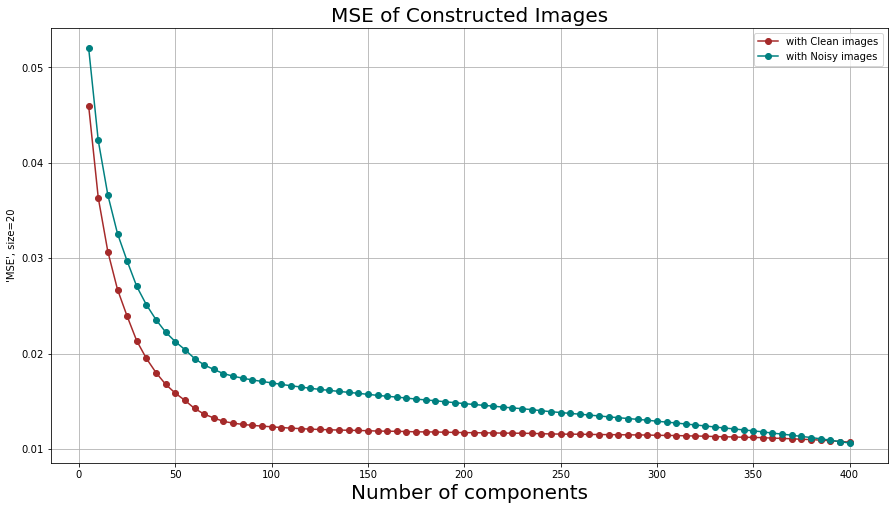

In [50]:
plt.figure(figsize=(15,8))
plt.plot(ms, mse_1, marker='o', linestyle='-', c='brown', label="with Clean images")
plt.plot(ms, mse_2, marker='o', linestyle='-', c='teal', label="with Noisy images")
plt.xlabel('Number of components', size=20)
plt.ylabel("'MSE', size=20")
plt.title('MSE of Constructed Images', size=20)
plt.grid()
plt.legend()

As the figure shows, the MSE in both cases decrease simultaneously, but the MSE with the clean images is always lower than the MSE with the noisy images. 

When $m$ is lower than 100, the MSE of clean images drops faster. This is because the first few principal components capture the most significant variations in the data. Thus the features about the signal (digit) is retained by using first few largest components, this is why when the $m$ is small, MSE with clean images is lower as at this stage, digit details are recovered, but the noises are not included yet.

While $m$ goes on, more and more features get explained by the components, it recovers more details about the digit, but at the same time, those smaller variances which represent the noise are also captured during this process. This is why while details of digits is gaining, the MSE with clean image is decreasing is a much slower pace. In contrast, while more noises are gained, the recovered images are more like to the noisy images, so when $m$ is large, MSE with noisy images is decreasing faster.

MSE with clean data always being lower suggests that although noises are recovered during later stage, they are still partially suppressed by PCA.

Now let us visualise some reconstructed images for using different amount of components.

In [51]:
ms = np.array([10, 40, 100, 200])
example_image = 50
images = np.zeros((784, 4))

for i, m in enumerate(ms):
    Xpca, eigenvectors, eigenvalues = PCA(Xmnist_noisy_std_train, m)
    Xpca_test = Xmnist_noisy_std_test.dot(eigenvectors)
    X_pca_reconstruct = Xpca_test.dot(eigenvectors.T)
    X_pca_reconstruct = standardise(Xmnist_noisy_train01, Xrevert=X_pca_reconstruct)
    images[:,i] = X_pca_reconstruct[example_image]

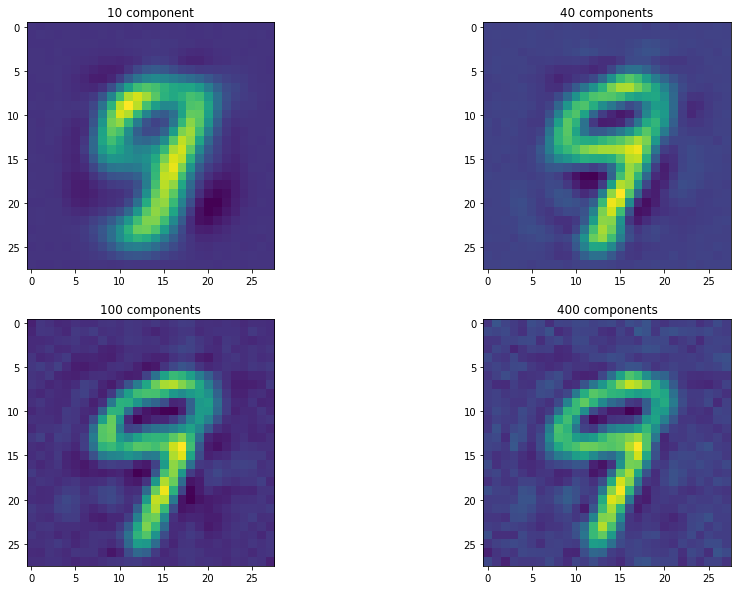

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(images[:, 0].reshape(28, 28))
ax[0, 0].set_title("10 component")

ax[0, 1].imshow(images[:, 1].reshape(28, 28))
ax[0, 1].set_title("40 components")

ax[1, 0].imshow(images[:, 2].reshape(28, 28))
ax[1, 0].set_title("100 components")

ax[1, 1].imshow(images[:, 3].reshape(28, 28))
ax[1, 1].set_title("400 components")

plt.show()

The four plots alings with my discussion above.

The 10 component image barely includes any noise, and we start to viualise the overall shape of the digit. Since the first 10 components explain the most variation which is the signal. This is the stage where MSE with clean data decreases quickly.

When $m$ increases to 20, the digit is getting clearer, as more variances are explained. However, some noises starts to get added back. This is the stage where MSE with noisy data starts to decrease.

When $m$ increases to 100, the digit is getting clearer again, at the same time, there are more noises included. 

The last image shows that, compared to $100$ components reconstruction, $400$ components only retain tiny more bit of digit details, but a lot of noises appear in it. This is where the MSE with clean data barely decreases, and the MSE with noisy data keep decreasing. 

This suggests that we should take an 'early stop', for example at $m$ around 80 to 100, where the digit are recovered mostly and little noise is captured.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

Upon request, let us take out the first 1000 images from the clean training set, and correspondingly the labels, and standardise the image set.

In [53]:
# Image set
Xmnist_train_1000 = mnist_train_numpy[:1000, 1:]
Xmnist_train_1000_std = standardise(Xmnist_train_1000 / 255.)
# Label set
ymnist_train_1000 = mnist_train_numpy[:1000,:1].flatten()

First of all, let us set up the class structure for Gaussian Mixture Model. EM-algorithm is used to fit our model.

In [54]:
class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution =  multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) # normal distribution
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) 

def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) 
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight  
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True) 

Now let us carry out the PCA with first 5 principle components used. 

By the nature of numpy algorithm, eigenvectors will be returned in complex from, same in our case (although with complex part being zero). To prevent error in casting imaginary to real later on, I will just take the real part of our transformed $X$ data.

In [55]:
Xpca_131, eigenvectors_131, eigenvalues_131 = PCA(Xmnist_train_1000_std, 5)
Xpca_131_real = Xpca_131.real.copy()

Now we use the Gaussian Mixture Model with 10 hidden components and $X_{\text{PCA}}$ as input.

Then the EM algorithm is used to train our GMM. A max iteration will be set for training, but we check the means and covariances of the 10 Gaussian components after each update. If both the changes in means and covariances are stable within a tolerance, we think the parameters are stable and the algorihtm has converged to a local optimum.

In [56]:
def GMM_EM(X, components, max_iter=1000, seed=0):
    """
    This function trains a Gaussian Mixture Model by using EM algorithm.
    
    :param X: 2d array, input data
    :param components: int, number of clusters (mixture components) in GMM
    :param max_iter: int, maximum number of training
    :param seed: int, a seed set for GMM distribution initialisation
    
    :return GMM: trained GMM
    :return labels:labels predicted by current GMM
    """
    np.random.seed(seed)
    GMM = GMModel(X, components)
    old_mu, old_sigma = GMM.mu.copy(), GMM.sigma.copy()

    labels = np.zeros(X.shape[0])
    for _ in range(1000):
        # EM fitting
        fitStep(GMM, X)
        # Predict labels based on likelihood
        new_labels = predict(GMM, X)
        
        # Check mean and covariance
        if np.allclose(old_mu, GMM.mu) and np.allclose(old_sigma, GMM.sigma):
            print(f"----Parameters of the Gaussian components unchanged by EM algorithm at iteration {_+1}----")
            break
        
        old_mu, old_sigma = GMM.mu.copy(), GMM.sigma.copy()
        
        # Update predicted labels
        labels = new_labels
    
    return GMM, labels

Now we perform clustering using a Gaussian Mixture Model with 10 hidden components. Predicted labels are reported.

In [57]:
GMM_131, labels_131 = GMM_EM(Xpca_131_real, 10)

----Parameters of the Gaussian components unchanged by EM algorithm at iteration 317----


From the output message, we can see that the EM algorithm has converged at iteration 317. Thus we are convenienced that our GMM model has been trained sucessfully. We now viualise the space spanned by the top two principal components.

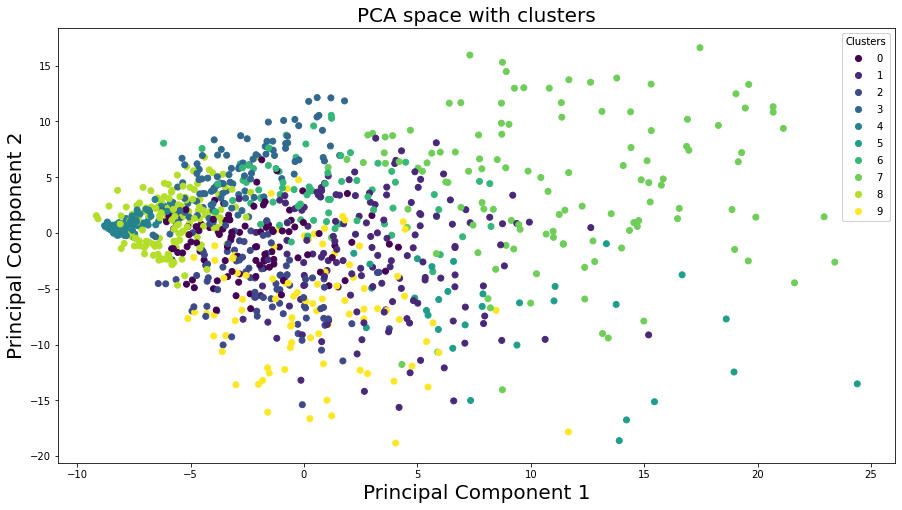

In [58]:
# Plot the clusters in the space spanned by the top two principal components
fig, ax = plt.subplots(figsize=(15,8))
scatter = ax.scatter(Xpca_131_real[:, 0], Xpca_131_real[:, 1], c=labels_131, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
plt.title("PCA space with clusters", size=20)
plt.xlabel('Principal Component 1', size=20)
plt.ylabel('Principal Component 2', size=20)
plt.show()

It can be seen that cluster 7 has been separated aside, yet the rest components are still somehow clustered together.

###### 1.3.2

In this section, I will color each label base on the ground truth -- class label.

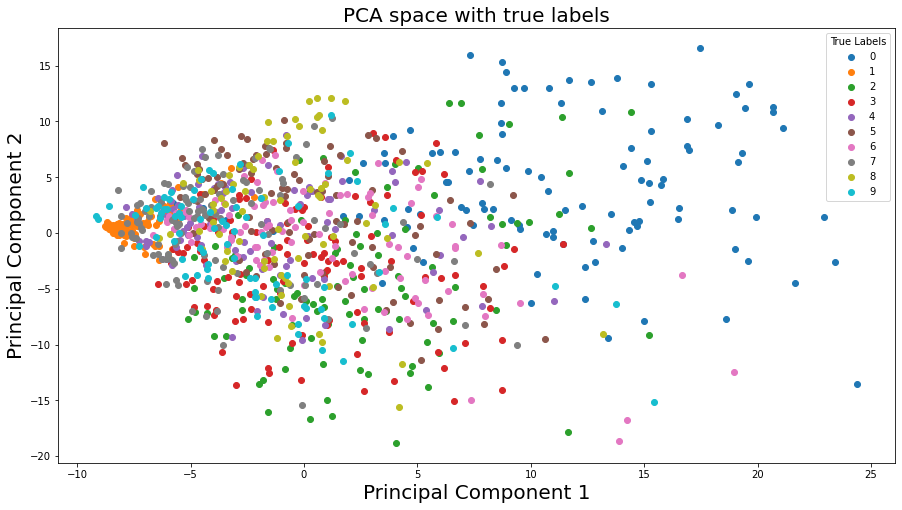

In [59]:
# Plot the clusters in the space spanned by the top two principal components
fig, ax = plt.subplots(figsize=(15,8))
for i, c in enumerate(np.unique(ymnist_train_1000)):
    plt.scatter(Xpca_131_real[ymnist_train_1000==c, 0],
                         Xpca_131_real[ymnist_train_1000==c, 1], label=c)
plt.title("PCA space with true labels", size=20)
plt.xlabel('Principal Component 1', size=20)
plt.ylabel('Principal Component 2', size=20)
plt.legend(title='True Labels')
plt.show()

We could tell the distribution of the plot is close to the distribution colored by cluster labels. Some difference exists but it is expected as GMM may not be accurate.

Now we map the true labels to the best-fitting cluster index given a training GMM model.

First, we iterate over each class label, select the images belongs to this label. Next for each Gaussian component (10 in our case), compute the log-likelihood of the selected images using the multivariate normal distribution with the current Gaussian component's mean and covariance.

Then sum the log-likelihoods for each Gaussian components, find the index of the component with the highest sum.  The class label is then mapped to the such component.

In [60]:
def Map_Labels(gmm, X, y):
    """
    This function maps class labels to cluster index with highest log-likelihood.
    
    :param gmm: trained GMM
    :param X: input data
    :param y: class labels
    
    :return class_cluster_mapping: dictionary, contain the mapping
    """
    class_cluster_mapping = {}
    for c in range(10):
        # Find images belonging to the class label
        class_indices = np.where(y == c)
        class_data = X[class_indices]
        log_likelihoods = np.zeros((class_data.shape[0], gmm.dim))
        
        # Iterate through each Gaussian Component
        for i in range(gmm.dim):
            distribution = multivariate_normal(mean=gmm.mu[i], cov=gmm.sigma[i])
            log_likelihoods[:, i] = distribution.logpdf(class_data)
        
        best_cluster = np.argmax(np.sum(log_likelihoods, axis=0))
        class_cluster_mapping[c] = best_cluster

    return class_cluster_mapping

We now perform the mapping and visualise the size of each cluster.

 Class Label  Best Cluster Index
           0                   7
           1                   4
           2                   9
           3                   1
           4                   6
           5                   7
           6                   1
           7                   6
           8                   7
           9                   2


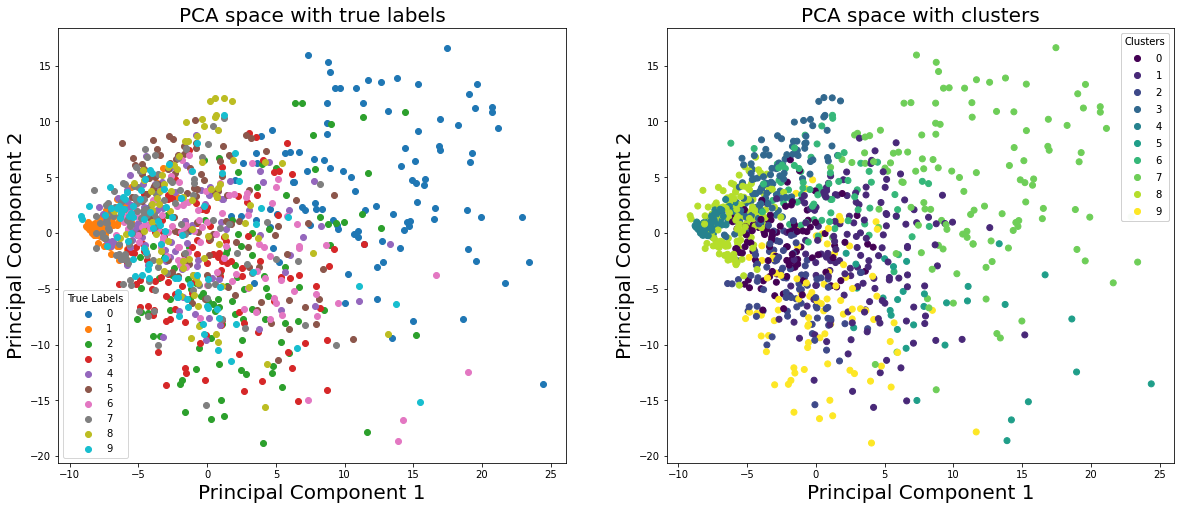

In [61]:
# Map
class_cluster_mapping_132 = Map_Labels(GMM_131, Xpca_131_real, ymnist_train_1000)

#Viualisation
mapping_df = pd.DataFrame(list(class_cluster_mapping_132.items()), 
                          columns=['Class Label', 'Best Cluster Index'])
mapping_df.reset_index(drop=True)
print(mapping_df.to_string(index=False))

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot the clusters in the space spanned by the top two principal components
ax = axes[0]
for i, c in enumerate(np.unique(ymnist_train_1000)):
    ax.scatter(Xpca_131_real[ymnist_train_1000==c, 0],
               Xpca_131_real[ymnist_train_1000==c, 1], label=c)
ax.set_title("PCA space with true labels", size=20)
ax.set_xlabel('Principal Component 1', size=20)
ax.set_ylabel('Principal Component 2', size=20)
ax.legend(title='True Labels')

# Plot the true labels in the space spanned by the top two principal components
ax = axes[1]
scatter = ax.scatter(Xpca_131_real[:, 0], Xpca_131_real[:, 1], c=labels_131, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
ax.set_title("PCA space with clusters", size=20)
ax.set_xlabel('Principal Component 1', size=20)
ax.set_ylabel('Principal Component 2', size=20)

plt.show()

From the mapping, we can observe the following:

1. Some class labels are mapped to the same cluster index. For example, classes 0, 5, and 8 are all mapped to cluster index 7, and classes 3 and 6 are both mapped to cluster index 1. This suggests that the GMM may have difficulty distinguishing between these classes, as they share similar features in the PCA-transformed space. These class pairs may have overlapping distributions, making them harder to separate.

2. Other class labels are mapped to distinct cluster indices, such as class 1 to cluster index 4, class 2 to cluster index 9, and class 9 to cluster index 2. This suggests that these classes are more distinguishable from the rest in the PCA-transformed space, and the GMM is better at identifying the distinct patterns for these classes.

If we compare the color of points between the two plots, we can see it largely follows our best-fitting mapping. Meanwhile, it seems that class label $0$ is the most easy label to be factored out, and it is mapped to cluster 7.


1.3.3


In this section, we calculate the probability of image $x^{(i)}$ in input data $X$ belonging to its best cluster $k$. We then viualise the results by cluster.

In [62]:
def Cluster_Prob(gmm, X, y, class_cluster_mapping):
    """
    This function calculates the probability of given image belonging to its best cluster.
    
    :param gmm: Trained GMM
    :param X: input data
    :param y: True class labels
    :param class_cluster_mapping: dictionary, mapping of true labels to best-fitting cluster
    """
    
    # Compute cluster probabilities for all data points
    cluster_probs = cluster_probabilities(gmm, X)

    # Set up colormap and create a custom legend with matching colors
    viridis = matplotlib.cm.get_cmap('viridis')
    colormap = ListedColormap(viridis(np.linspace(0, 1, 10)))

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
    
    # Iterate through each class index
    for c in range((np.unique(y)).size):
        ax = axes[c // 5, c % 5]

        # Use the LogNorm to color points based on probability
        norm = mcolors.LogNorm()
        # For each true label, find its best cluster index
        best_cluster = class_cluster_mapping[c]
        # Find those images in this cluster
        class_indices = np.where(y == c)
        class_data = X[class_indices]
        # Probability of these images in the assgined cluster
        best_cluster_probabilities = cluster_probs[class_indices, best_cluster]
        
        # Visualization
        scatter = ax.scatter(class_data[:, 0], class_data[:, 1],
                             c=best_cluster_probabilities, cmap=colormap, norm=norm)

        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('P(k|X) for Best-Fitting Cluster', size=14)

        ax.set_title(f"PCA Space with P(k|X) for Class {c}", size=14)
        ax.set_xlabel('Principal Component 1', size=14)
        ax.set_ylabel('Principal Component 2', size=14)

    plt.tight_layout()
    plt.show()


We now take it the trained GMM, dimensional-reduced clean training set, and best-fitting cluster index found in section 1.3.2, and the true label from training set.

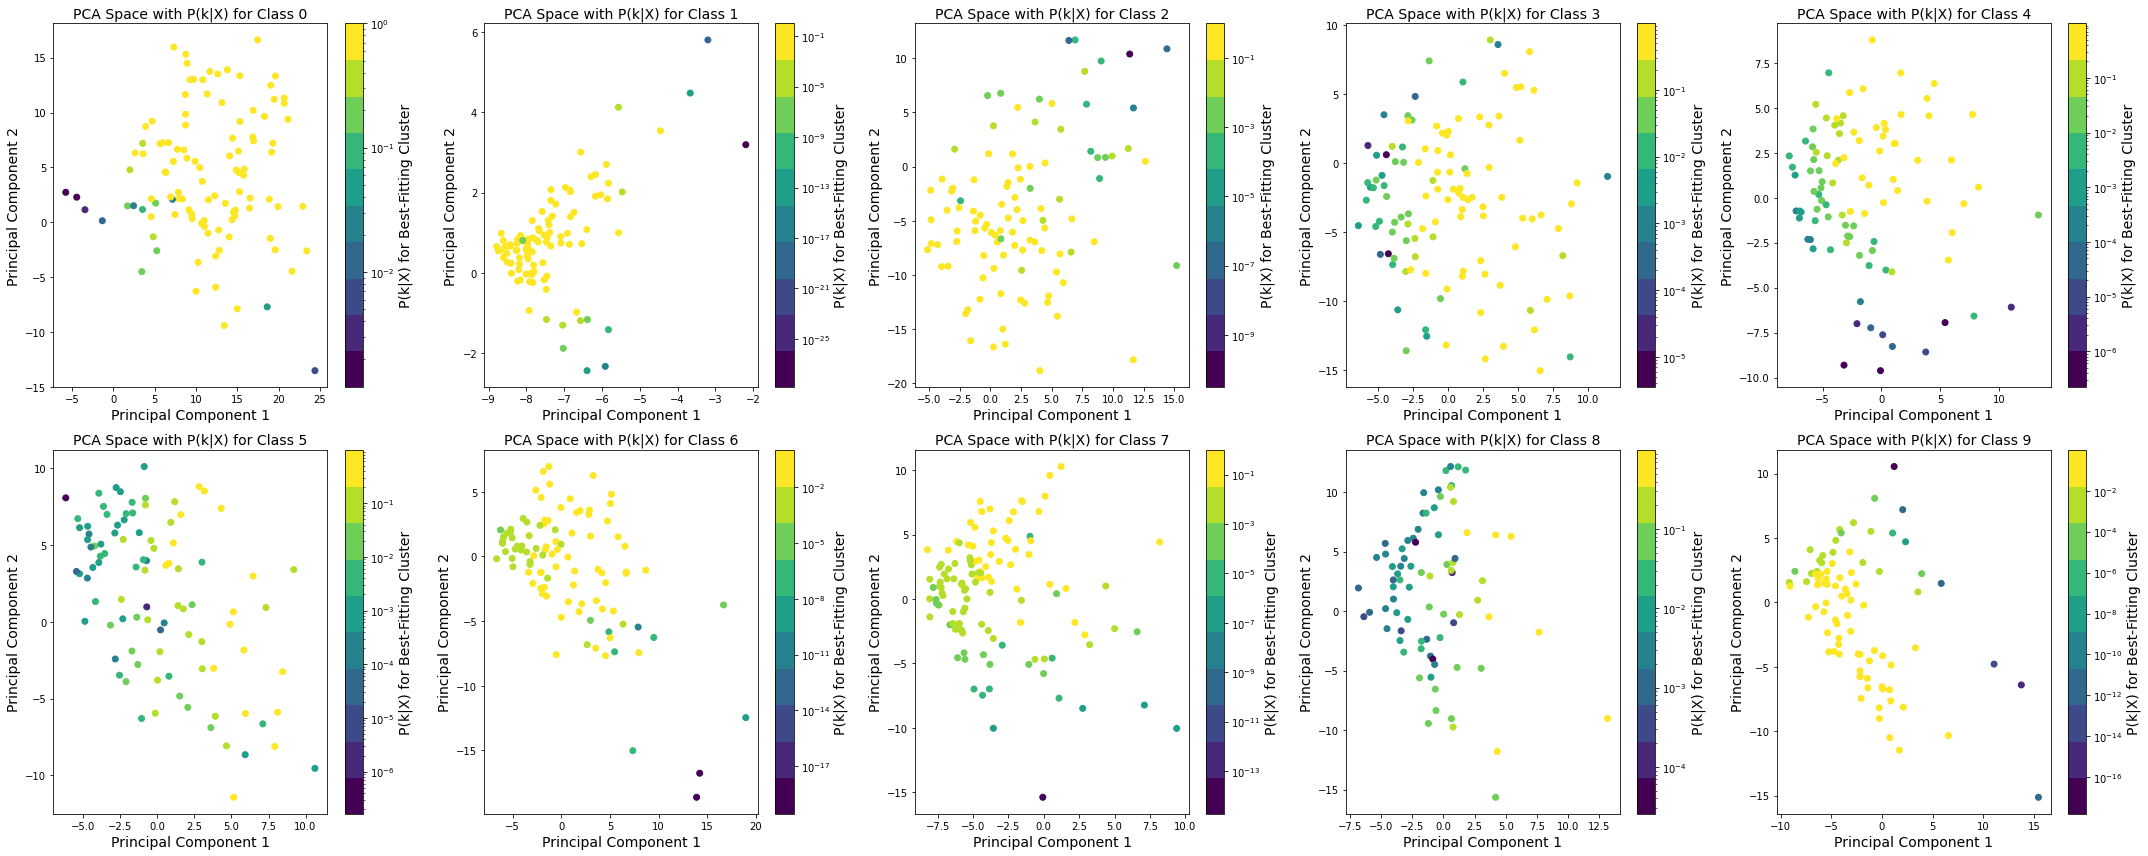

In [63]:
Cluster_Prob(GMM_131, Xpca_131_real, ymnist_train_1000, class_cluster_mapping_132)

From the intensity of the color, we can tell different clusters have different certainty in assignments. In our heatmap, yellow points represent high probability, while green/blue points represent low probability.

Most classes are having lots of yellow points, for example class 0, 1, 2, 6, 7, 9. These classes have low uncertainty, meaning the GMM is confident in assigning data points to the best-fitting cluster for these class. The GMM effectively captures the structure of these classes in the PCA space, resulting in high certainty for the cluster assignments.

In contrast, class 5 and 8 have mix of color. These classes have high uncertainty, meaning the GMM is less confident in assigning data points to the best-fitting cluster for each class. This might occur if the classes have high intra-class variability, or if they overlap significantly with other classes in the PCA space. As a result, the GMM has difficulty confidently assigning images to the best-fitting cluster for these classes.


1.3.4

In this section, we retrain the GMM with a reduced number of 5 and 8components respectively. Then we compute the maps of the class labels to best-fitting index

In [64]:
# 5 components
GMM_5, labels_5 = GMM_EM(Xpca_131_real, 5)
# 8 components
GMM_8, labels_8 = GMM_EM(Xpca_131_real, 8)

# Map
class_cluster_mapping_5 = Map_Labels(GMM_5, Xpca_131_real, ymnist_train_1000)
class_cluster_mapping_8 = Map_Labels(GMM_8, Xpca_131_real, ymnist_train_1000)

----Parameters of the Gaussian components unchanged by EM algorithm at iteration 234----
----Parameters of the Gaussian components unchanged by EM algorithm at iteration 399----


By the output message, both EM fittings converged. 

Now let us viualise the mapping for 5, 8 and 10 components alongside each other.

             Best-fitting Idx (5)  Best-fitting Idx (8)  Best-fitting Idx (10)
Class label                                                                   
0                               3                     7                      7
1                               4                     4                      4
2                               1                     1                      9
3                               1                     1                      1
4                               2                     2                      6
5                               3                     1                      7
6                               1                     1                      1
7                               2                     2                      6
8                               3                     1                      7
9                               1                     2                      2


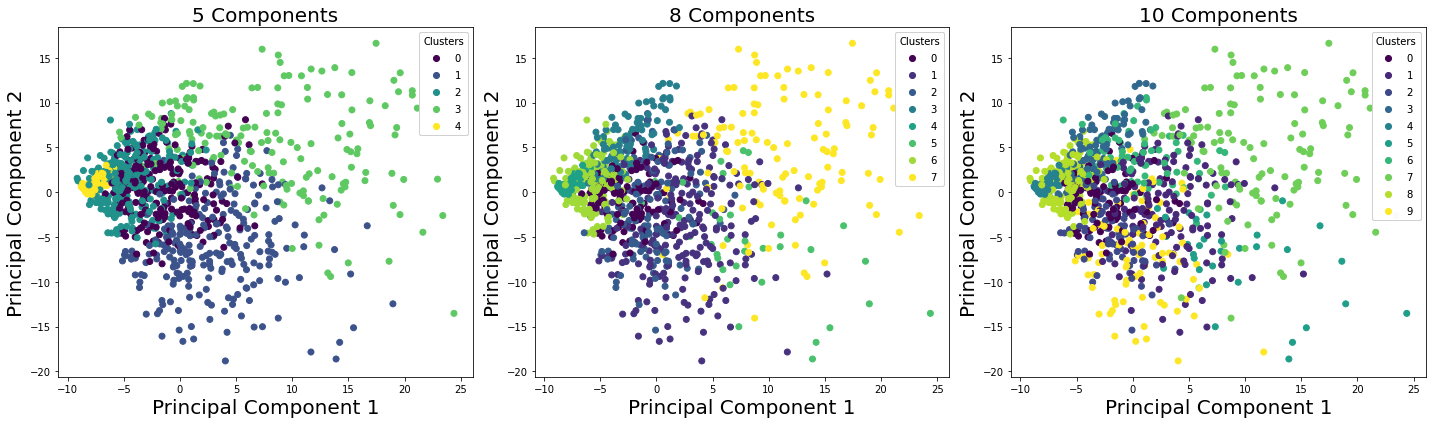

In [65]:
combined_data = [
    {
     "Best-fitting Idx (5)": class_cluster_mapping_5[k],
     "Best-fitting Idx (8)": class_cluster_mapping_8[k],
     "Best-fitting Idx (10)": class_cluster_mapping_132[k]}
    for k in class_cluster_mapping_5.keys()
]
df = pd.DataFrame(combined_data)
df.index.name = "Class label"
print(df)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 5 Components
scatter_5 = axes[0].scatter(Xpca_131_real[:, 0], Xpca_131_real[:, 1], c=labels_5, cmap='viridis')
legend_5 = axes[0].legend(*scatter_5.legend_elements(), loc="upper right", title="Clusters")
axes[0].add_artist(legend_5)
axes[0].set_title("5 Components", size=20)
axes[0].set_xlabel('Principal Component 1', size=20)
axes[0].set_ylabel('Principal Component 2', size=20)

# 8 Components
scatter_8 = axes[1].scatter(Xpca_131_real[:, 0], Xpca_131_real[:, 1], c=labels_8, cmap='viridis')
legend_8 = axes[1].legend(*scatter_8.legend_elements(), loc="upper right", title="Clusters")
axes[1].add_artist(legend_8)
axes[1].set_title("8 Components", size=20)
axes[1].set_xlabel('Principal Component 1', size=20)
axes[1].set_ylabel('Principal Component 2', size=20)

# 10 Components
scatter_131 = axes[2].scatter(Xpca_131_real[:, 0], Xpca_131_real[:, 1], c=labels_131, cmap='viridis')
legend_131 = axes[2].legend(*scatter_131.legend_elements(), loc="upper right", title="Clusters")
axes[2].add_artist(legend_131)
axes[2].set_title("10 Components", size=20)
axes[2].set_xlabel('Principal Component 1', size=20)
axes[2].set_ylabel('Principal Component 2', size=20)

plt.tight_layout()
plt.show()

The above table shows the best-fitting cluster index for each class label (digit) using Gaussian Mixture Models with 5, 8, and 10 components.

From the table, we can make a few observations:

1. As the number of components in the GMM increases, the best-fitting cluster index for some class labels changes. This is expected since having more components allows for a more flexible model, which can capture the underlying structure of the data better.

2. Some class labels have the same best-fitting cluster index across different GMMs. For example, class label 1 has the best-fitting index of 4 in all three GMMs. This suggests that the underlying structure of class label 1 is well-captured by a single cluster, regardless of the number of components in the GMM. Same applys to label 3 and 6 where they both get mapped to cluster 1.

3. Some class labels share the same best-fitting cluster index in the same GMM. For instance, in the 5-component GMM, class labels 3, 6, and 9 have the best-fitting index of 1. This might imply that these class labels have similar characteristics in the data or that the GMM with 5 components is not flexible enough to capture the differences between these class labels accurately.

4. In general,  as the number of components in the GMM increases, there is a tendency for the best-fitting cluster indices to become more diverse. For example. when $m=5$, only 4 clusters are best-fitted, yet when $m=10$, there are 6 best-fitted clusters. It shows that a higher number of components can better capture the differences between class labels, lead to a more accurate representation of the underlying structure of each class label, but it also means that the model might be more complex and harder to interpret.

In summary, the table indicates that the best-fitting cluster index for each class label can change with the number of components in the GMM. A more flexible GMM (with more components) might better capture the underlying structure of the class labels.

We can also visualise the space spanned by the principal components, coloured by clusters from 5-component, 8-component, and 10-component GMMs. In all three cases, class label $0$ is the easiest to be factored out. And in general, by checking the color of each cluster in each plot, we can see it aligns with the best-fitting mapping we found above.

Last but not least, let us plot the cluster probabilities of different GMMs.

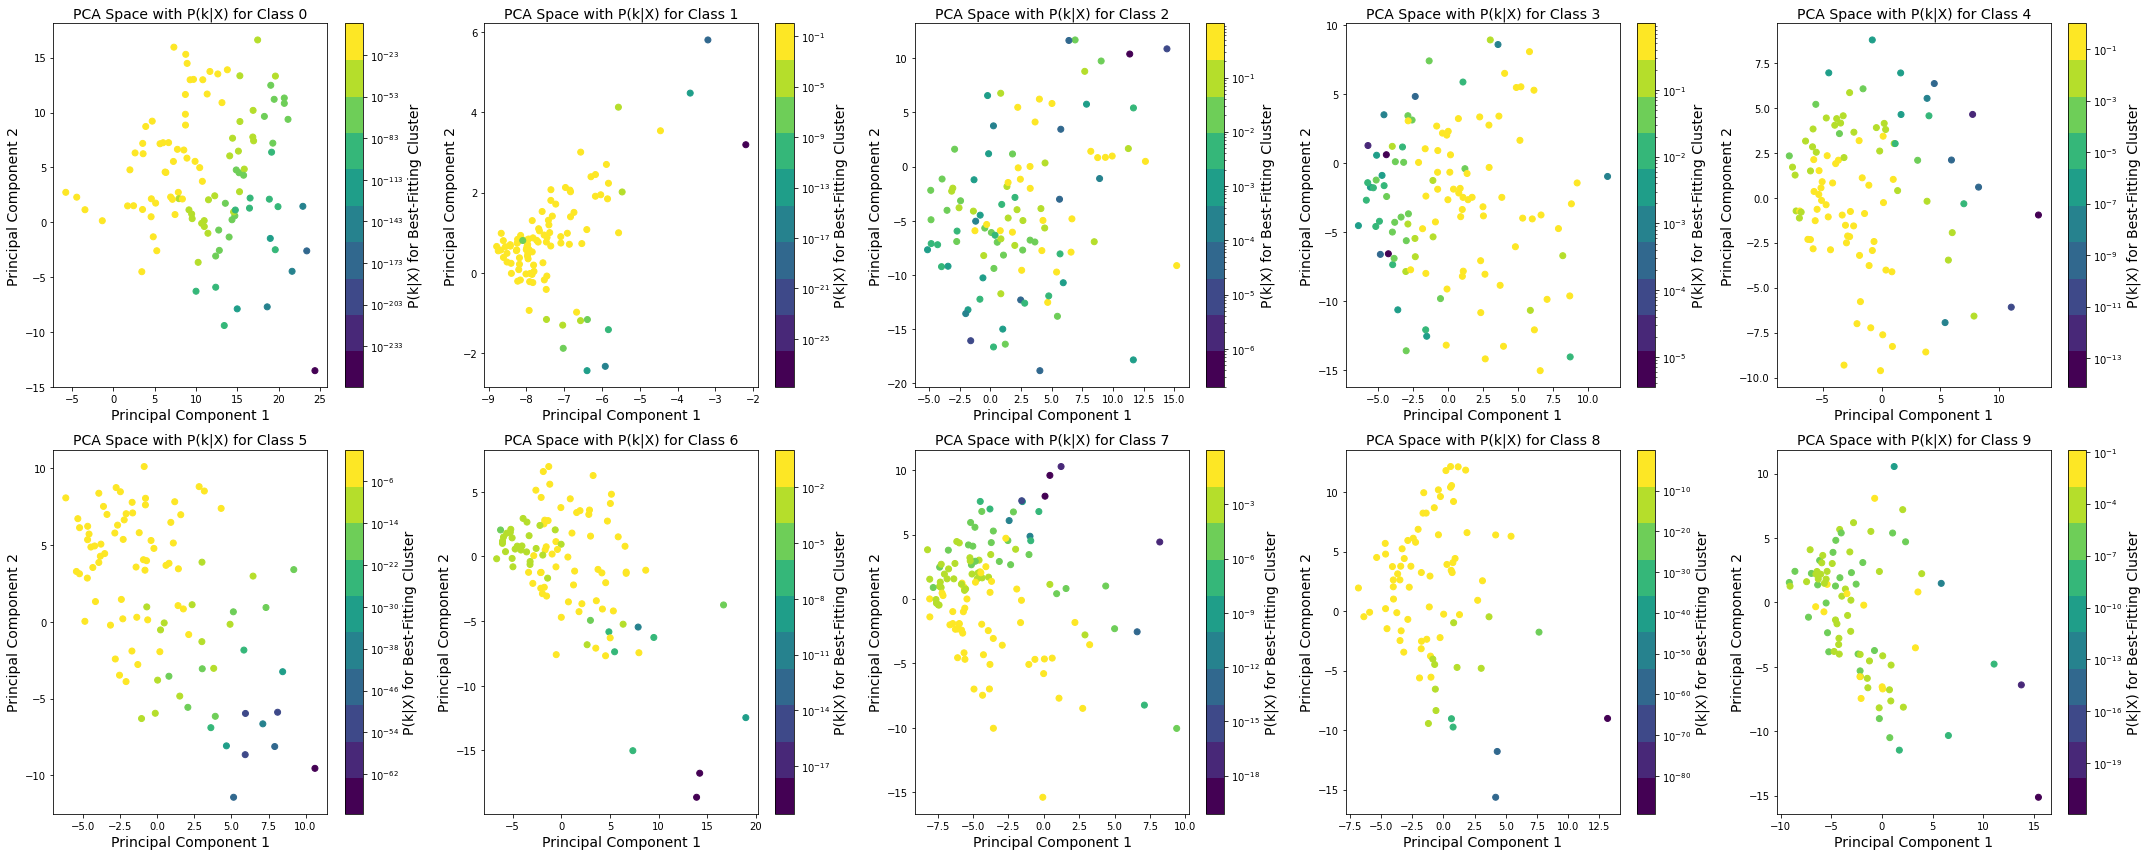

In [66]:
Cluster_Prob(GMM_131, Xpca_131_real, ymnist_train_1000, class_cluster_mapping_5)

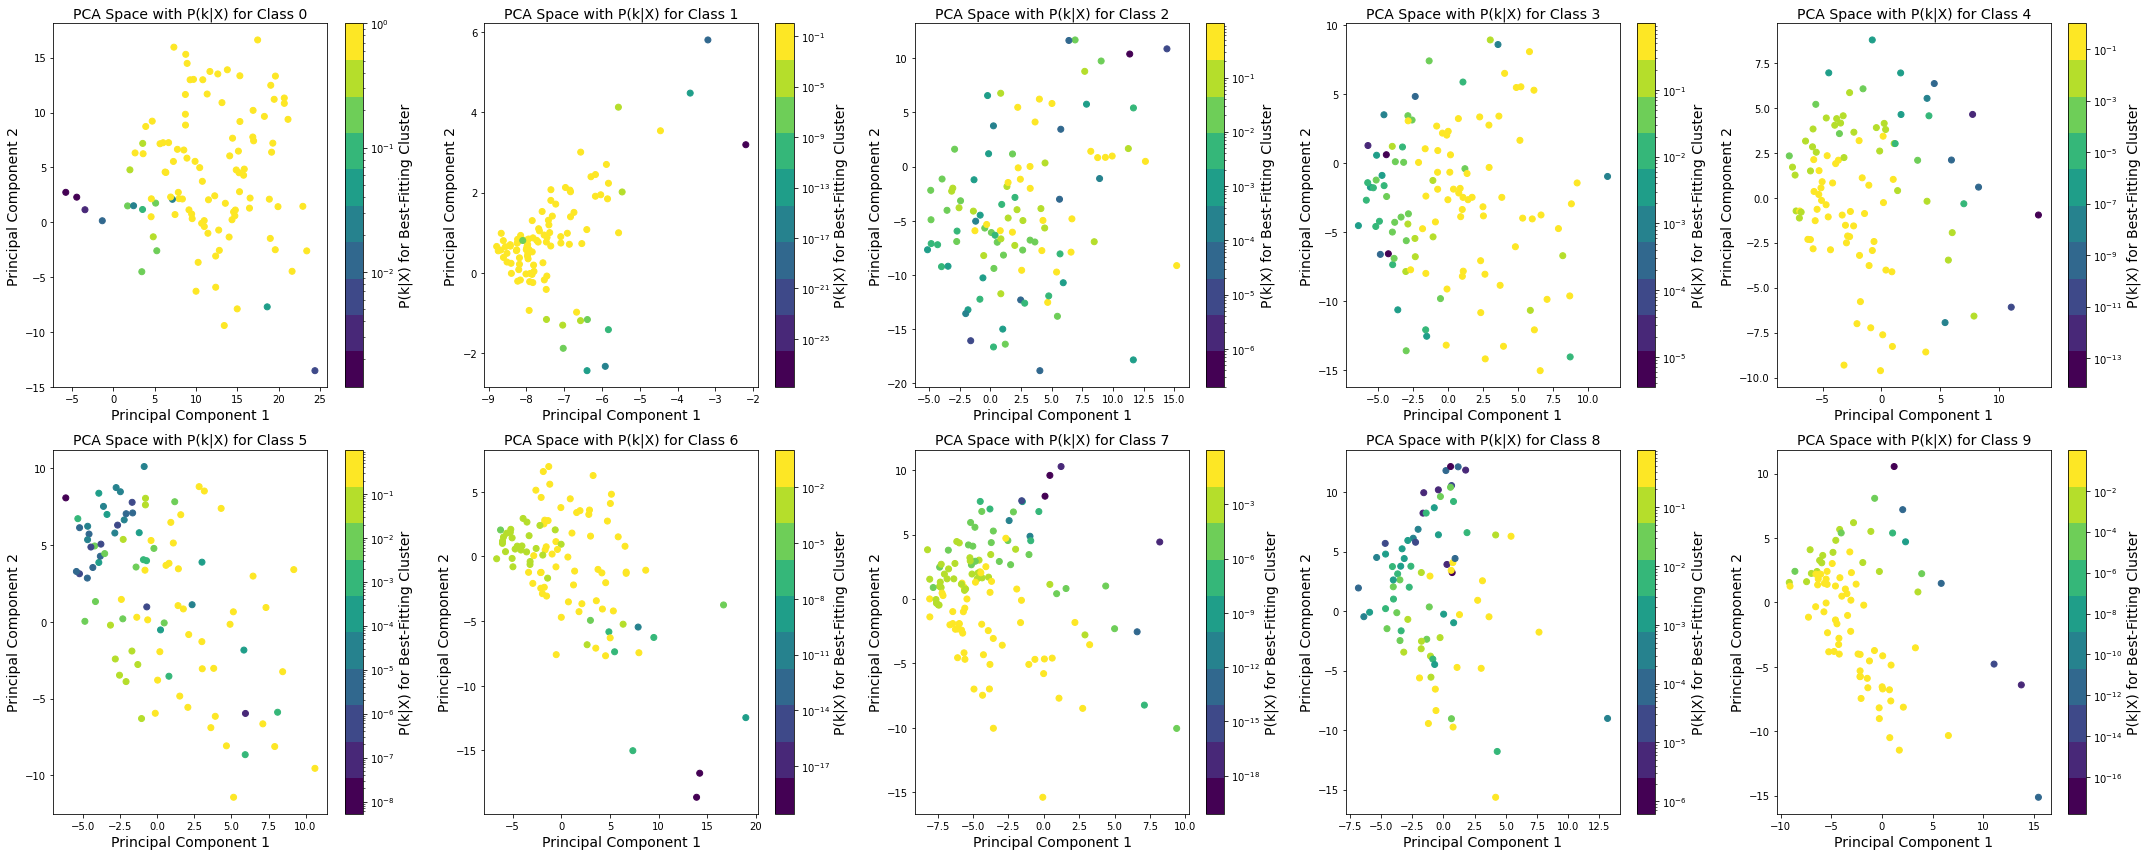

In [67]:
Cluster_Prob(GMM_131, Xpca_131_real, ymnist_train_1000, class_cluster_mapping_8)

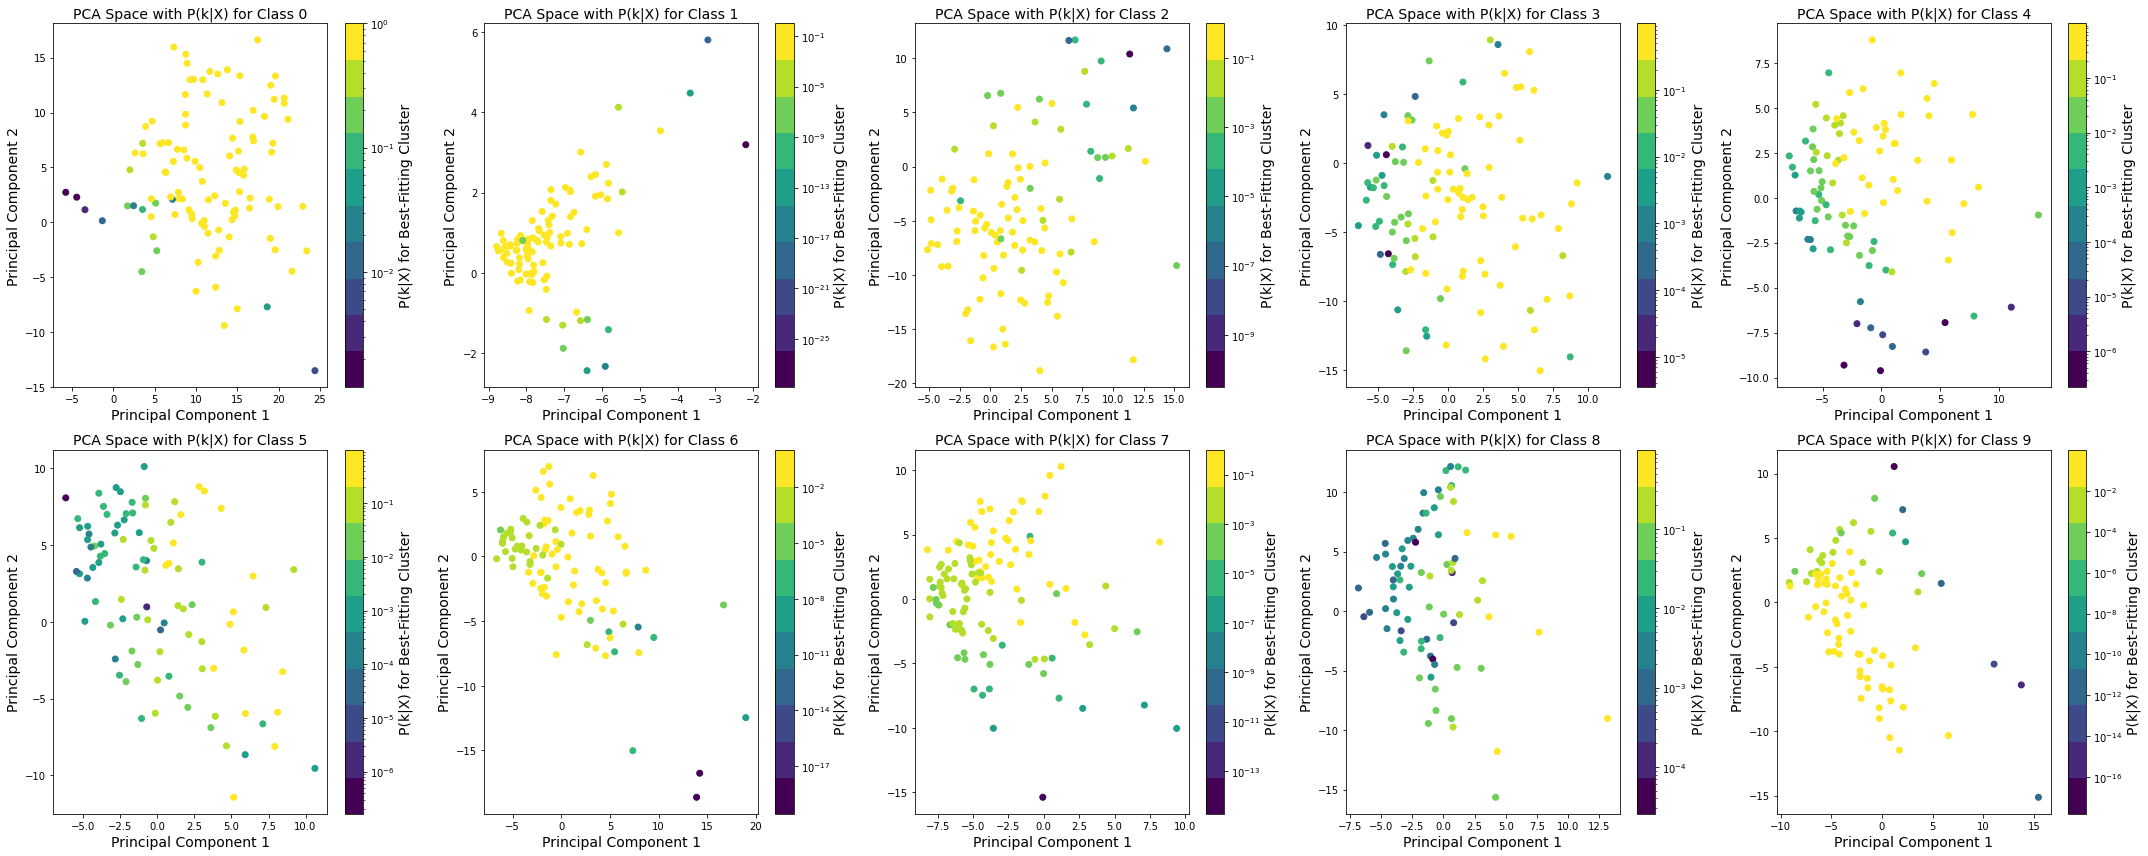

In [68]:
Cluster_Prob(GMM_131, Xpca_131_real, ymnist_train_1000, class_cluster_mapping_132)

For some class labels, such as Class 0, Class 2, Class 9, as the number of components increases, more yellow points appear, which demonstrates higher probability. This means GMM with more components is better at finding the charactertis or underlying pattern of these images.

For Class 1, Class 3, the probability plots does not alter much as the number of components increase. This means 5 components are enough to capture the underlying pattern of these two classes. 

For Class 4, Class 5, Class 8, the yellow points actually get less as number of components increase. This suggests that our GMM model is getting overfitting , 5-component or 8-component GMM is better at clustering out this classes than 10-component GMM.

This suggests that we might want to use different components GMM for clustering out different class labels.

This results also align with our dicussion: as the number of components increases, GMM has more flexibility to model complex data distribution. This leads to better performace for some classes, but the performace for some classes might not improve significantly, and in some cases, it might even degrade.

## Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
###### 2.1.1

In this task, our target dataset is about the measurements of gene expression in different tumor samples. Our aim is to identify groups of samples with shared gene expression patterns use k-means clustering.

To begin with, let us load the dataset and check its validity.

In [69]:
gene_data = pd.read_csv('gene_expression_data.csv')

# Validity check
print("---Check for numerical columns (without 'Type' column)---")
print(all([gene_data[column].dtype.kind in 'iufcb' for column in gene_data.columns[:-1]]))
print("---Check for Inf/NaN (All columns)---")
print((gene_data.isin([np.inf, -np.inf]).any() & gene_data.isnull().any()).any())
# Visualise first five rows
gene_data.head()

---Check for numerical columns (without 'Type' column)---
True
---Check for Inf/NaN (All columns)---
False


,Gene 0,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,...,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Type
0,9.796088,0.591871,0.591871,0.000000,11.420571,13.453759,4.411847,5.412334,10.771613,10.225665,...,5.974369,8.086513,12.727750,15.205717,6.438116,6.412577,0.000000,6.814730,13.618145,PRAD
1,10.070470,0.000000,0.000000,0.000000,13.085672,14.531863,10.462298,9.832926,13.520312,13.968046,...,0.000000,0.000000,11.197204,12.993933,10.800746,10.749811,0.000000,11.445610,0.000000,LUAD
2,8.970920,0.000000,0.452595,0.000000,8.263119,9.754908,8.964549,9.948113,8.693773,8.776111,...,3.907160,5.324101,11.487066,13.380596,6.656236,10.209734,0.000000,7.748830,12.759976,PRAD
3,8.524616,1.039419,0.434882,0.000000,10.798520,12.263020,7.440695,8.062343,8.802083,9.237487,...,4.296083,6.959747,12.974639,14.891812,6.030725,7.315648,0.434882,7.117924,12.353276,PRAD
4,8.047238,0.000000,0.000000,0.360982,12.283010,14.033759,8.719180,8.831472,8.462073,8.211202,...,0.000000,0.000000,11.337237,13.390061,5.989593,8.359671,0.000000,6.327545,0.000000,BRCA


We can see from the printed message that the columns which contains expression levels of genes are all numerical, and no invalid value (Inf/NaN) is included in our dataset. We are good to proceed with the current dataset.

First, I split the dataset into descriptor set and target set. By convention, we standardise the descriptor set before proceeding.

In [70]:
# Descriptor set
Xgene = gene_data.to_numpy()[:,:-1]
Xgene = np.array(Xgene, dtype=np.float64)
Xgene_std = standardise(Xgene) # Standardise

# Target set
ygene = gene_data.to_numpy()[:,-1]

We start with defining the function to compute the Calinski-Harabasz index of a given clustering:
$$
CH_k = \frac{BCSM}{k-1} \cdot \frac{n-k}{WCSM}
$$
where $n$ is the total number of points and $k$ is the number of clusters. 

BCSM and WCSM are defined as follows:
$$
\text{BCSM} = \sum_{i=1}^k n_i \cdot d(z_i, z_{\text{total}})^2 \quad \text{and} \quad \text{WCSM} = \sum_{i=1}^k \sum_{x \in c_i} d(x, z_i)^2
$$
where $z_i$ is the center of cluster $c_i$, $n_i$ is the number of points in $c_i$, $x$ is the data point beloing to cluster $c_i$. 

Higher CH index indicates a better suitable parition for the dataset.

In [71]:
def CH_index(X, labels, k):
    """
    This function calculates the Calinski-Harabasz index of given clustering labels.
    
    :param X: 2d array, representing the input data points
    :param labels: 1d array, representing the initial cluster labels for each data point
    :param k: int, the number of clusters in the data
    
    :return CH: float, the Calinski-Harabasz index for the given clustering labels
    """
    
    def euclidean_distance(x, y):
        """Compute the Euclidean distance between two points x and y."""
        return np.sqrt(np.sum((x - y) ** 2))

    n, m = X.shape

    # Find the centroid for each cluster (if one cluster is empty, set it to zero)
    cluster_centers = np.array([np.mean(X[labels == i], axis=0) if i in labels else np.zeros(m) for i in range(k)])
    # Centroid for all data point
    overall_center = np.mean(X, axis=0)

    # Compute BCSM
    BCSM = np.sum([np.sum(labels == i) * euclidean_distance(cluster_centers[i], overall_center) ** 2 for i in range(k)])

    # Compute WCSM
    WCSM = np.sum([np.sum([euclidean_distance(X[j], cluster_centers[i]) ** 2 for j in range(n) 
                           if labels[j] == i]) for i in range(k)])

    # Compute Calinski-Harabasz index
    CH = (BCSM / (k - 1)) * ((n - k) / WCSM)

    return CH

Then, let us define a function to perform the k-means clustering algorithm to achieve cluster labels for each gene expression.

To make the output message neat, I choose not to print whether the k-means clustering terminates before reaching max iteration. Instead, I return a boolean variable to indicates the status of clustering. This is used as the 'convergence check'.

In [72]:
def kmeans(X, k, initial_labels, max_iteration, centroid=False):
    """
    This function performs k-means clustering on the input data X, given a specified number of clusters k,
    initial labels, and a maximum number of iterations.

    :param X: 2d array, representing the input data points
    :param k: int, the number of clusters to be formed
    :param initial_labels: 1d array, representing the initial cluster labels for each data point
    :param max_iteration: int, the maximum number of iterations for the k-means algorithm
    :param centroid: boolean, whether return the final centroids for each cluster

    :return labels: 1d array, representing the final cluster labels for each data point
    :return centroid: 1d array, contrains the center for each cluster
    :return boolean: boolean variable, check whether the k-means cluster terminates before max iteration
    """

    n_samples, n_features = X.shape

    labels = initial_labels
    new_labels = np.zeros(len(labels))
    
    # Initialize centroids
    centroids = np.zeros((k, n_features))
    for i in range(k):
        # Only update centroids if the label exists
        if (labels == i).any():
            centroids[i] = np.mean(X[labels == i], axis=0)
    
    # Iteratively update labels and centroids
    for i in range(max_iteration):
        # Compute distances from data points to centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # Update labels based on the closest centroid
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # Labels unchanged, terminate k-means clustering
            labels = new_labels
            if centroid:
                return labels, centroids, True
            else:
                return labels, True
             
        else:
            # Report the final percentage change if max iteration reached
            if i == max_iteration - 1:
                difference = np.mean(labels!=new_labels) 
                print('%4f%% labels changed at final iteration' % (difference * 100))
                
            # Update labels and centroids for the next iteration
            labels = new_labels
            for c in range(k):
                # Only update centroids when a label exists
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    if centroid:
        return labels, centroids, False
    else:
        return labels, False

Now we write a grid search function to search across a range of $k$, and use the Calinski-Harabasz index to quantify the performance of our clustering. 

Upon request, for each $k$, we use 5 different initialisations and average the corresponding Calinski-Harabasz indices.

In [73]:
def kmeans_search(X, krange, max_iteration):
    """
    This function calculates the average Calinski-Harabasz index for different sizes of clustering k
    
    :param X: 2d array, representing the input data points
    :param krange: 1d array, contains all the k we need to search across
    :param max_iteration: int, the maximum number of iterations for the k-means algorithm
    
    :return all_CH: 1d array, contain the average CH index for each k
    :return booleans: 1d array, conatin all the convergence check
    """
    n_samples, n_features = X.shape
    all_CH = np.zeros(len(krange))
    booleans = np.array([])
    for i, k in enumerate(krange):
        for _ in range(5):
            np.random.seed(i*_) # set new seed for each iteration
            initial_label = np.random.randint(0, k, n_samples)
            labels, boolean = kmeans(X, k, initial_label, max_iteration)
            all_CH[i] += CH_index(X, labels, k)
            booleans = np.append(booleans, boolean)
        all_CH[i] /= 5
    
    return all_CH, booleans

If we set $k=1$, the Calinski-Harabasz index will not be correctly defined. Also, we know there are 5 different types of tumor in the dataset, it is unreasonable to classify all the genes into 1 cluster. Therefore, we start with $k=2$, and search all the way up to $k=50$.

In [74]:
k_range = np.arange(2, 51, 1)
CH_index211, booleans211 = kmeans_search(Xgene_std, k_range, max_iteration=200)
print('-----Convergence Check------')
print("Every clustering is terminated before reaching max iteration: ", booleans211.all())

-----Convergence Check------
Every clustering is terminated before reaching max iteration:  True


From the output message, we can see all the clusterings are terminated before reaching max iteration. It is an indication that all the clustering succeeded.

Now let us viualise the Calinski-Harabasz index against the size of clusters.

-----------------------------------------
Optimal size of clusters:  4
Highest Average Calinski-Harabasz Score:  233.02675130057588


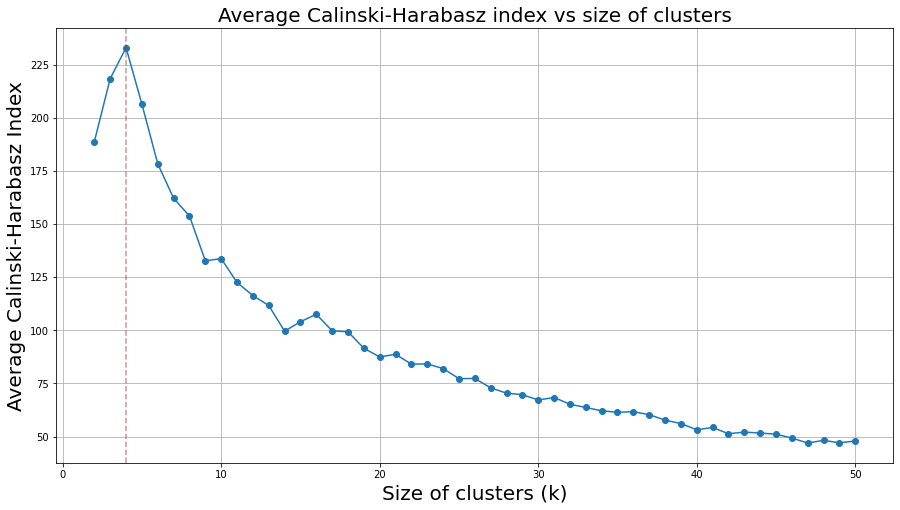

In [75]:
plt.figure(figsize=(15,8))
plt.plot(k_range, CH_index211, linestyle='-', marker='o')
plt.axvline(x=k_range[np.argmax(CH_index211)], alpha=0.5, linestyle='--', c='brown')
plt.xlabel('Size of clusters (k)', size=20)
plt.ylabel('Average Calinski-Harabasz Index', size=20)
plt.grid()
plt.title('Average Calinski-Harabasz index vs size of clusters', size=20)

print('-----------------------------------------')
print("Optimal size of clusters: ", k_range[np.argmax(CH_index211)])
print("Highest Average Calinski-Harabasz Score: ", np.max(CH_index211))

It can be seen that using $k=4$ clusters gives us the highest average Calinski-Harabasz index. And for all $k$ larger than 4, the index is decreasing (although not monotonically), it is an indication that $k=4$ is a global maximum. 

As mentioned before, higher Calinski-Harabasz index represents better partition of the dataset. Therefore, we determine the optimal $k$ as $4$.

In [76]:
# K-means clustering with optimal k
np.random.seed(28) # random seed
k = 4
initial_labels = np.random.randint(0, k, Xgene_std.shape[0])
opt_cluster_labels, opt_boolean = kmeans(Xgene_std, k, initial_labels, 500)

print('--------------------------------------------------------')
print("K-means clustering is terminated before reaching max_iteration: ", opt_boolean)
# Find unique labels and their counts
unique_labels, counts = np.unique(opt_cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label+1}: {count} elements")

--------------------------------------------------------
K-means clustering is terminated before reaching max_iteration:  True
Cluster 1: 135 elements
Cluster 2: 221 elements
Cluster 3: 304 elements
Cluster 4: 140 elements


Our clustering is terminated before max iteration, it means all the labels are correctly clustered by our algorithm.

We are not necessarily know what types are in each cluster, we only know that one type (cluster) has 135 elements, one has 221 elements, one has 304 elements, and the last one has 140 elements.

###### 2.1.2

In this task, let us assess the consistency between the clustering of samples using 4-means clustering and the true labels of the tumour types. This is done by calculating the homogeneity score. Follow the instruction in the coursework, a function is defined as below:

In [77]:
def homogeneity_score(true_labels, cluster_labels):
    """
    This function calculates the homogeneity score between true and clustered labels.
    A pseduo epsilon is added to a_ck if it is being zero.
    
    :param true_labels: True labels of each tumour types
    :param cluster_labels: Labels obtained from the k-means clustering
    
    :return homogeneity: float, the homogeneity score
    """
    n = len(true_labels)
    true_ids, true_counts = np.unique(true_labels, return_counts=True)
    cluster_ids = np.unique(cluster_labels)

    # Compute contingency matrix a_ck
    a_ck = np.zeros((len(true_ids), len(cluster_ids)))
    for i, true_id in enumerate(true_ids):
        for j, cluster_id in enumerate(cluster_ids):
            a_ck[i, j] = np.sum((true_labels == true_id) & (cluster_labels == cluster_id))

    # Compute H(C|K)
    hc_k = -np.sum((a_ck / n) * np.log((a_ck / np.sum(a_ck, axis=0, keepdims=True)) + 1e-15))

    # Compute H(C)
    hc = -np.sum((true_counts / n) * np.log(true_counts / n + 1e-15))

    # Compute homogeneity score
    homogeneity = 1 - hc_k / hc

    return homogeneity

We now perform the k-means clustering with the optimal $k=4$. 

In [78]:
homogeneity = homogeneity_score(ygene, opt_cluster_labels)

print('------------------------------------')
print("Homogeneity Score:", homogeneity)

------------------------------------
Homogeneity Score: 0.5815045673429746


The homogeneity score is about $0.58$. It indicates a moderate level of consistency between the clustering of the samples and the true assignment to these classes. Our clustering algorithm has identified some underlying structure in the data that is consistent with the true class labels. However, the clustering is not perfect, and there is still some mixing of classes within the clusters. This could indicate that the clusters are not completely separated in the feature space, or the clustering algorithm has not fully captured the structure of the data. 

This moderate level of consistency can be expected, because we have 5 different types of tumour, while our optimal clusters size is 4, thus the consistency will not be very high. It could also be an indication that one pair of tumours is having a similar gene expression. This could be a reason why only 4 clusters are needed.


#### 2.2 Graph-based analysis (20 marks)
###### 2.2.1

In this section, we first calculate the correlation between genes (columns), and use it as a similarity matrix to construct a graph that links genes. Then I create a weighted adjacency matrix of graph.

In [79]:
def corr_adjacency_matrix(X, threshold=0.75):
    """
    This function creates an adjancy matrix based on the connected correlations
    between genes. Correlation with magnitude less than 0.75 is set to zero.
    
    :param X: 2d array, input date
    :param threshold: float, threshould for correlation, default at 0.75
    
    :return adjacency_matrix: 2d array, weighted adjacency matrix
    """
    # Calculate the correlation matrix
    correlations = np.corrcoef(X, rowvar=False)

    # Set diagonal elements to zero
    np.fill_diagonal(correlations, 0)

    # Set elements with an absolute value smaller than the threshold to zero
    adjacency_matrix = np.where(np.abs(correlations) >= threshold, correlations, 0)

    return adjacency_matrix

Text(0, 0.5, 'Gene')

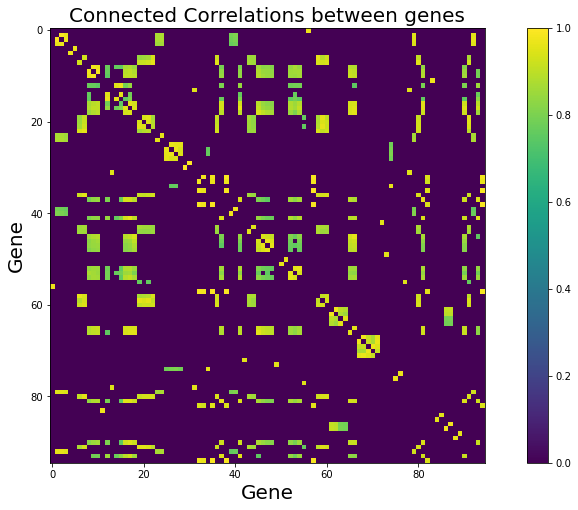

In [80]:
# Weighted adjancy matrix
A = corr_adjacency_matrix(Xgene_std)

plt.figure(figsize=(15,8))
plt.imshow(A)
plt.colorbar()
plt.title('Connected Correlations between genes', size=20)
plt.xlabel('Gene', size=20)
plt.ylabel('Gene', size=20)

From the heatmap we can see that most genes are not correlated to others. But there indeed are some highly correlated pairs, which are demonstrated by yellow and green colors in the plot. In general there isn't any pattern for the correlation, but one could suspect the neighbor genes could be correlated, as there are yellow/green around the diagonal. 

###### 2.2.2

By lecture notes, given adjacancy matrix $A$, the degree of the graph can be calculated as
$$
d = A1
$$
which is essentially the row sum of the adjancy matrix. Base on the instruction on Ed Discussion forum, we could use the weighted adjacency matrix to compute the degree.

The degree centrality is then defined as 
$$
c_d = \frac{d}{2E}
$$
where $E$ is the number of edge defined by
$$
E = \frac{1}{2}\sum_{i=1}^N d_i
$$

In [81]:
weighted_degree = A.sum(axis=1)
E = 1/2 * sum(weighted_degree)
degree_centrality = weighted_degree / (2 * E)

Now we find the top 5 genes with highest degree centrality.

In [82]:
# Indices of nodes with highest to lowest centrality
sorted_indices = np.argsort(degree_centrality)[::-1]
top_genes = sorted_indices[:5]
print("-------Top 5 ranking genes by degree centrality-------")
for i in range(len(top_genes)):
    print(f"Rank {i+1}: Gene {top_genes[i]}\
          (degree centrality: {degree_centrality[top_genes[i]]})")

-------Top 5 ranking genes by degree centrality-------
Rank 1: Gene 17          (degree centrality: 0.026873435141916795)
Rank 2: Gene 41          (degree centrality: 0.025935453030435724)
Rank 3: Gene 16          (degree centrality: 0.02537837392050003)
Rank 4: Gene 81          (degree centrality: 0.02523066217538562)
Rank 5: Gene 90          (degree centrality: 0.024870225673900563)


As a higher degree centrality indicates that the gene has more connections to other genes and may play a more significant role in the overall network. The output message suggests that Gene 17, Gene 41, Gene 16, Gene 81, Gene 90 could play important roles in the graph due to their numerous connections with other genes.

###### 2.2.3

Now let us construct the symmetric normalised Laplacian,
$$
L = I - D^{-1/2}AD^{-1/2}
$$

In [83]:
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
D_inv_sqrt = np.diag(weighted_degree_sqrt)
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

To clarify, in the code below, I classify all the eigenvalues with magnitude less than 1e-10 as zero.

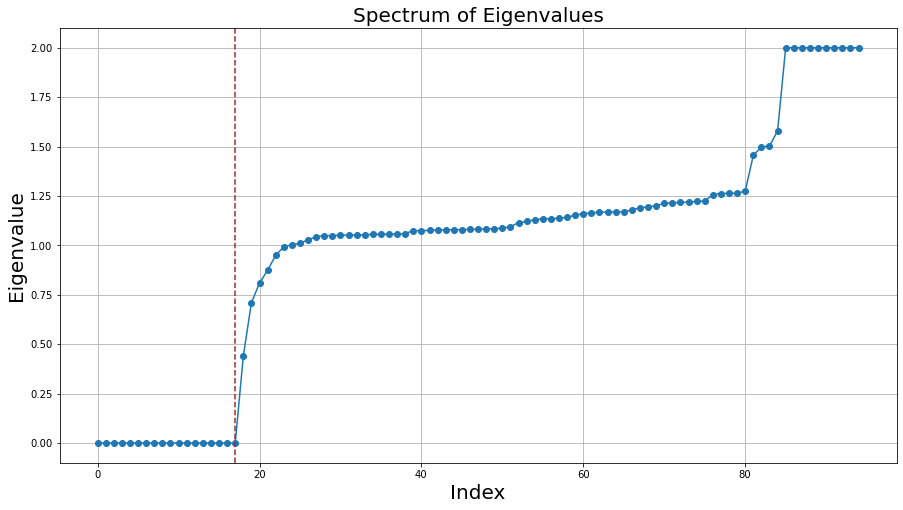

Number of zero eigenvalues: 18


In [84]:
eigenvalues223, eigenvectors223 = scipy.linalg.eigh(L_norm)
sort_indices223 = np.argsort(eigenvalues223)
zero_eigenvalues = eigenvalues223[np.isclose(eigenvalues223, 0, atol=1e-10)]

plt.figure(figsize=(15, 8))
plt.plot(np.sort(eigenvalues223), 'o-')
plt.axvline(x=len(zero_eigenvalues)-1, linestyle='--', c='brown')
plt.xlabel('Index', size=20)
plt.ylabel('Eigenvalue', size=20)
plt.title('Spectrum of Eigenvalues', size=20)
plt.grid()
plt.show()

print(f"Number of zero eigenvalues: {len(zero_eigenvalues)}") 

Base on the construction in the lecture notes, the number of components of the graph, corresponds to the number of zero eigenvalues of Laplacian matrix. 

Thus, we can conclude that there are 18 components in our gene network.

###### 2.2.4

Given $U$ be the matrix containing all the eigenvectors of the symmetric normalised Laplacian corresponding to zero eigenvalues as columns. Now normalise U by setting
$$
T_{ij} = \frac{U_{ij}}{\sqrt{\sum_k {U_{ik}}^2}}
$$

In [85]:
# Set up matrix U
zero_indices = sort_indices223[:len(zero_eigenvalues)]
U = eigenvectors223[:, zero_indices]
# Normalisation of U
T = U / np.sqrt((U**2).sum(axis=1, keepdims=True))

Now given a clustering $\{c_l\}_{l=1}^k$, we can calculate the within cluster distance by
$$
W(C) = \frac{1}{2}\sum_{l=1}^k \frac{1}{|c_l|}\sum_{i,j \in c_l} \| x^{(i)} - x^{(j)}\|^2
$$

In [86]:
def within_cluster_distance(X, labels, centroids):
    """
    This function calculates the within cluster distance given data X, labels and centroids.
    
    :param X: 2d array, input dataset
    :param labels: 1d array, cluster lables for each data point
    :param centroids: 1d array, centers for each cluster
    
    :return W: float, the within cluster distance
    """
    def euclidean_distance(x, y):
        return np.sqrt(np.sum((x - y)**2, axis=-1))
    
    k = len(centroids)
    W = 0
    for i in range(k):
        # Factorise out data in this cluster
        cluster_points = X[labels == i]
        cluster_size = len(cluster_points)
        if cluster_size > 0:
            distances = np.array([[euclidean_distance(x, y)**2
                                   for x in cluster_points] for y in cluster_points])
            W += 0.5 * (1 / cluster_size) * np.sum(distances**2)
    return W

Still we search across a range of $k$ and use the elbow method to find the optimal $k$.

For each $k$, I will repeat with 50 different initialisation, and record the minimum within cluster distance for each $k$.

In [87]:
# 50 initialisation for each k
m = 50
# Search across 2 to 50
krange = np.arange(2, 51, 1)

Ws = np.zeros(len(krange))
Wmin = np.zeros(m)
convergence = np.zeros(len(krange))

for i, k in enumerate(krange):
    for j in range(m):
        np.random.seed(j*i) # random seed
        initial_labels = np.random.randint(0, k, T.shape[0])
        labels, centroids, boolean = kmeans(T, k, initial_labels, 200, centroid=True)
        convergence[i] = boolean
        Wmin[j] = within_cluster_distance(T, labels, centroids)
    # Choose the minimum distance 
    Ws[i] = np.min(Wmin)
        
print('----Convergence Check of k-means clustering----')
print('All clustering have converged before reaching max iteration: ', convergence.all())

----Convergence Check of k-means clustering----
All clustering have converged before reaching max iteration:  True


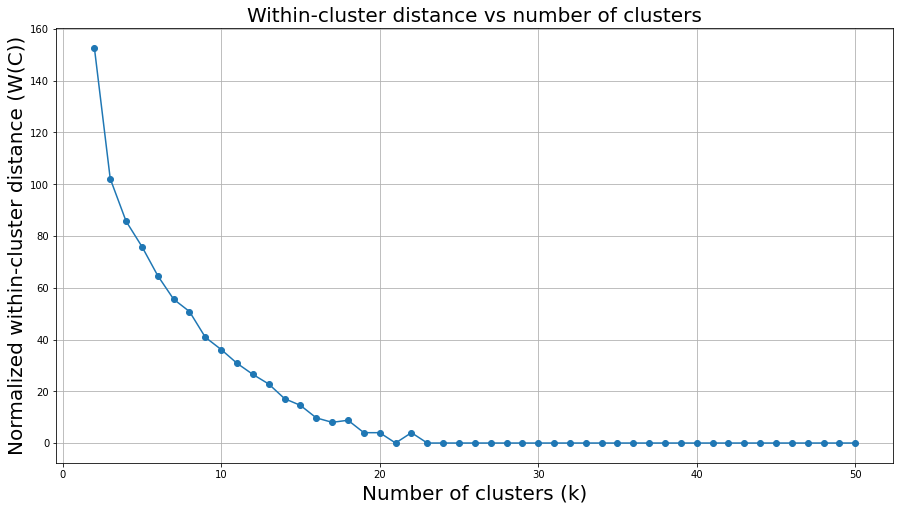

In [88]:
plt.figure(figsize=(15,8))
plt.plot(krange, Ws, 'o-')
plt.xlabel('Number of clusters (k)', size=20)
plt.ylabel('Normalized within-cluster distance (W(C))', size=20)
plt.title('Within-cluster distance vs number of clusters', size=20)
plt.grid()
plt.show()

By visualising the plot, we can see at $k=23$, $W(C)$ reaches zero. And for $k>23$, $W(C)$ stays at zero, without any further change.  Thus, by elbow method, we chooose $k=23$ as our optimal.

Then we use this optimal $k$ to perform the k-means and find clustered labels. After that, let us viualise the size of each cluster.

In [89]:
opt_k224 = 23
np.random.seed(0)
initial_labels224 = np.random.randint(0, opt_k224, T.shape[0])
labels224, centroids224, boolean = kmeans(T, opt_k224, initial_labels224, 200, centroid=True)
print('----Convergence Check of k-means clustering----')
print('Cclustering have converged before reaching max iteration: ', boolean)

----Convergence Check of k-means clustering----
Cclustering have converged before reaching max iteration:  True


The k-means has converged, and let us proceed with the results.

In [90]:
clusters = {i: [] for i in range(opt_k224)}
for i, label in enumerate(labels224):
    clusters[label].append(i)

for i in range(opt_k224):
    print(f"Cluster {i + 1}: {len(clusters[i])} genes")

Cluster 1: 9 genes
Cluster 2: 6 genes
Cluster 3: 23 genes
Cluster 4: 2 genes
Cluster 5: 4 genes
Cluster 6: 0 genes
Cluster 7: 0 genes
Cluster 8: 0 genes
Cluster 9: 16 genes
Cluster 10: 0 genes
Cluster 11: 2 genes
Cluster 12: 8 genes
Cluster 13: 4 genes
Cluster 14: 0 genes
Cluster 15: 4 genes
Cluster 16: 2 genes
Cluster 17: 6 genes
Cluster 18: 7 genes
Cluster 19: 0 genes
Cluster 20: 0 genes
Cluster 21: 0 genes
Cluster 22: 0 genes
Cluster 23: 2 genes


From the output message, we can see that:
1. Clusters 1, 2, 3, 4, 5, 9, 11, 12, 13, 15, 16, 17, 18, and 23 have genes assigned to them. The number of genes in each cluster varies, with some clusters having more genes than others. This suggests that there are varying degrees of similarity among the genes, with some groups of genes sharing more similar attributes than others.
2. Cluster 3 has the most genes (23), indicating that this cluster contains a large group of genes with similar characteristics. This cluster may represent a more general or common set of gene features.
3. Clusters 4, 11, 16, and 23 have the fewest genes (2 each), suggesting that the genes in these clusters have unique characteristics that set them apart from the majority of the other genes. These clusters may represent more specialized or rare gene features.
4. Clusters 6, 7, 8, 10, 14, 19, 20, 21, and 22 have no genes assigned to them. This indicates that the number of clusters specified in the k-means algorithm (23 in this case) may be more than needed to accurately represent the underlying structure of the data. It is possible that a smaller number of clusters would better capture the patterns within the gene data.


###### 2.2.5

Let us first find the gene indeces from the cluster with largest size.

In [91]:
# Index of largest cluster
largest_cluster_index = -1
# Size of largest cluster
largest_cluster_size = 0

# Search for the largest cluster
for cluster_index, genes in clusters.items():
    if len(genes) > largest_cluster_size:
        largest_cluster_size = len(genes)
        largest_cluster_index = cluster_index
        
# Gene in the largest cluster
largest_cluster = clusters[largest_cluster_index]

Then we construct a weighted adjancency matrix for this subgraph. And calculate the symmetric normalised laplacian by the same algortihm as above.

In [92]:
# Adjanceny for the subplot
A_sub = A[np.ix_(largest_cluster, largest_cluster)]
# Calculate L_norm
weighted_degree_sub = A_sub.sum(axis=1)
weighted_degree_sqrt_sub = 1.0 / np.sqrt(weighted_degree_sub)
D_inv_sqrt_sub = np.diag(weighted_degree_sqrt_sub)
Lnorm_sub = np.eye(A_sub.shape[0]) - D_inv_sqrt_sub.dot(A_sub.dot(D_inv_sqrt_sub))

Since the gene in this graph are all clustered into the same cluster, this will be a connected graph. Thus we would only expect one zero eigenvalues.

A binary partition is then performed base on the eigenvector of the second smallest eigenvalue.

In [93]:
eigenvalue225, eigenvector225 = scipy.linalg.eigh(Lnorm_sub)
# Find the second smallest eigenvalue
second_smallest_eigenvalue_index = np.argsort(eigenvalue225)[1]
# Find the corresponding eigenvector
second_eigenvector = eigenvector225[:, second_smallest_eigenvalue_index]
# Binary partition
partition_labels = np.where(second_eigenvector >= 0, 1, 0)

In [94]:
# Split the gene indices into two sets based on the partition labels
partition1 = [idx for idx, label in zip(largest_cluster, partition_labels) if label == 0]
partition2 = [idx for idx, label in zip(largest_cluster, partition_labels) if label == 1]

# Create submatrices of A_sub for each partition and for the links across the two partitions
A_sub_partition1 = A_sub[np.ix_(partition_labels == 0, partition_labels == 0)]
A_sub_partition2 = A_sub[np.ix_(partition_labels == 1, partition_labels == 1)]
A_sub_cross = A_sub[np.ix_(partition_labels == 0, partition_labels == 1)]

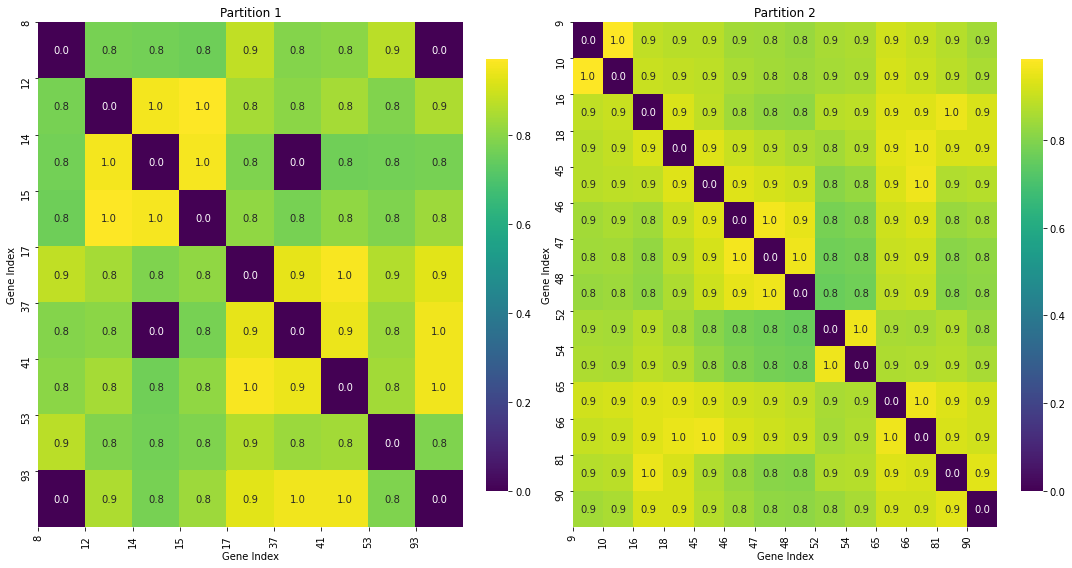

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot for Partition 1
sns.heatmap(A_sub_partition1, cmap='viridis', annot=True, fmt='.1f', ax=ax1, cbar_kws={'fraction': 0.046})
ax1.set_title('Partition 1')
ax1.set_xlabel('Gene Index')
ax1.set_ylabel('Gene Index')
ax1.set_xticks(range(len(partition1)))
ax1.set_yticks(range(len(partition1)))
ax1.set_xticklabels(partition1, rotation=90)
ax1.set_yticklabels(partition1)

# Plot for Partition 2
sns.heatmap(A_sub_partition2, cmap='viridis', annot=True, fmt='.1f', ax=ax2, cbar_kws={'fraction': 0.046})
ax2.set_title('Partition 2')
ax2.set_xlabel('Gene Index')
ax2.set_ylabel('Gene Index')
ax2.set_xticks(range(len(partition2)))
ax2.set_yticks(range(len(partition2)))
ax2.set_xticklabels(partition2, rotation=90)
ax2.set_yticklabels(partition2)

plt.tight_layout()
plt.show()

The correlation map shows a good result of clustering and partitioning.

Partition 1 only has 4 paris of uncorrelated genes and the rest  are high correlated. This partition seems to be homogeneous, with most genes having similar patterns.

In partition 2, every pair of genes are highly correlated. This suggests that the genes in this partition may have very similar expression patterns or other attributes, and they might be involved in the same biological processes or pathways.

Now let us compare the cross-partioning correlation.

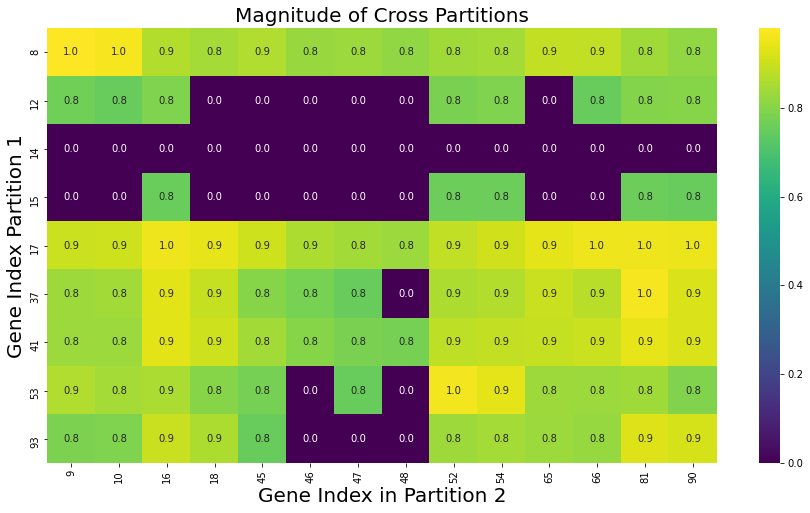

In [96]:
# Plot for Cross Partitions
plt.figure(figsize=(15, 8))
sns.heatmap(A_sub_cross, cmap='viridis', annot=True, fmt='.1f', xticklabels=partition2, yticklabels=partition1)
plt.title('Magnitude of Cross Partitions', size=20)
plt.xlabel('Gene Index in Partition 2', size=20)
plt.ylabel('Gene Index Partition 1', size=20)
plt.xticks(rotation=90)
plt.show()

There are a few more pairs becomes uncorrelated, but not too many.

This means that the clustering has sucessfully grouped together genes with similar characteristics into one cluster. And the partitioning process further separates genes in this cluster with weaker relationships.

###### 2.2.6

Let us consider the degree centrality of our subgraph, and I will find the top 5 genes with highest centrality, and compare them alongside with the results from the full graph.

In [97]:
# Calculate degree centrality
d226 = A_sub.sum(axis=1)
E226 = 1/2 * sum(d226)
degree_centrality226 = d226 / (2 * E226)

# Sort and find top five centrality gene
sorted_indices226 = np.argsort(degree_centrality226)[::-1]
top_genes226 = sorted_indices226[:5]

print('------Comparison of top 5 ranking gene-------')
sorted_indices = np.argsort(degree_centrality)[::-1]
top_genes = sorted_indices[:5]
for i, gene_index in enumerate(top_genes226):
    original_index = largest_cluster[gene_index]
    print(f"--------Rank {i+1}--------")
    print(f"In full: Gene {top_genes[i]}\
          (degree centrality: {degree_centrality[top_genes[i]]})")
    print(f"In largest cluster: Gene {original_index}\
          (degree centrality: {degree_centrality226[gene_index]})")

------Comparison of top 5 ranking gene-------
--------Rank 1--------
In full: Gene 17          (degree centrality: 0.026873435141916795)
In largest cluster: Gene 17          (degree centrality: 0.052890322343379356)
--------Rank 2--------
In full: Gene 41          (degree centrality: 0.025935453030435724)
In largest cluster: Gene 41          (degree centrality: 0.05104425480617879)
--------Rank 3--------
In full: Gene 16          (degree centrality: 0.02537837392050003)
In largest cluster: Gene 16          (degree centrality: 0.04994785259560676)
--------Rank 4--------
In full: Gene 81          (degree centrality: 0.02523066217538562)
In largest cluster: Gene 81          (degree centrality: 0.04965713718197441)
--------Rank 5--------
In full: Gene 90          (degree centrality: 0.024870225673900563)
In largest cluster: Gene 90          (degree centrality: 0.04894775251837666)


We can see that the top 5 genes are exactly identical in both graphs. This suggests that our k-means clustering has successfully grouped together the genes with the highest degree of connectivity. Although from section 2.2.4, there is a risk of overfitting by choosing this large $k$ (as some clusters are left empty), but it at least is appropriate for capturing the underlying structure of the gene network, and identifying the most significant subnetwork.

This result also shows that the largest cluster represents a dense and highly connected subnetwork within the full gene network. The presence of the overall top 5 centrality genes in this cluster highlights its importance in the overall network and suggests that the genes within this cluster are likely to be functionally related or co-regulated.

Last but not least, it is worth noticing that for all the top 5 ranking genes, their degree centrality values increase when considering only the largest cluster compared to the full network. This indicates that these genes have a higher proportion of connections within the largest cluster and may play more important roles in this specific cluster. The results highlight that the largest cluster has a higher concentration of highly connected genes, which could be crucial for understanding the underlying biological processes or pathways in the network.